## Pulses Tutorial

### Pulse

#### Overview

The `Pulse` object represents the radio-frequency pulses that are used to control qubits. 
The new version of `Pulse` object includes the following changes:
- It includes a new attribute `finish` that returns the point in time when the pulse finishes (start + duration).
- The `phase` attribute was replaced with `relative_phase`, since taking care of the global sequence phase is now done by the `PulseSequence`.
- The attributes `offset_i` and `offset_q` included in the previous version were removed, as those are parameters of the instrument.


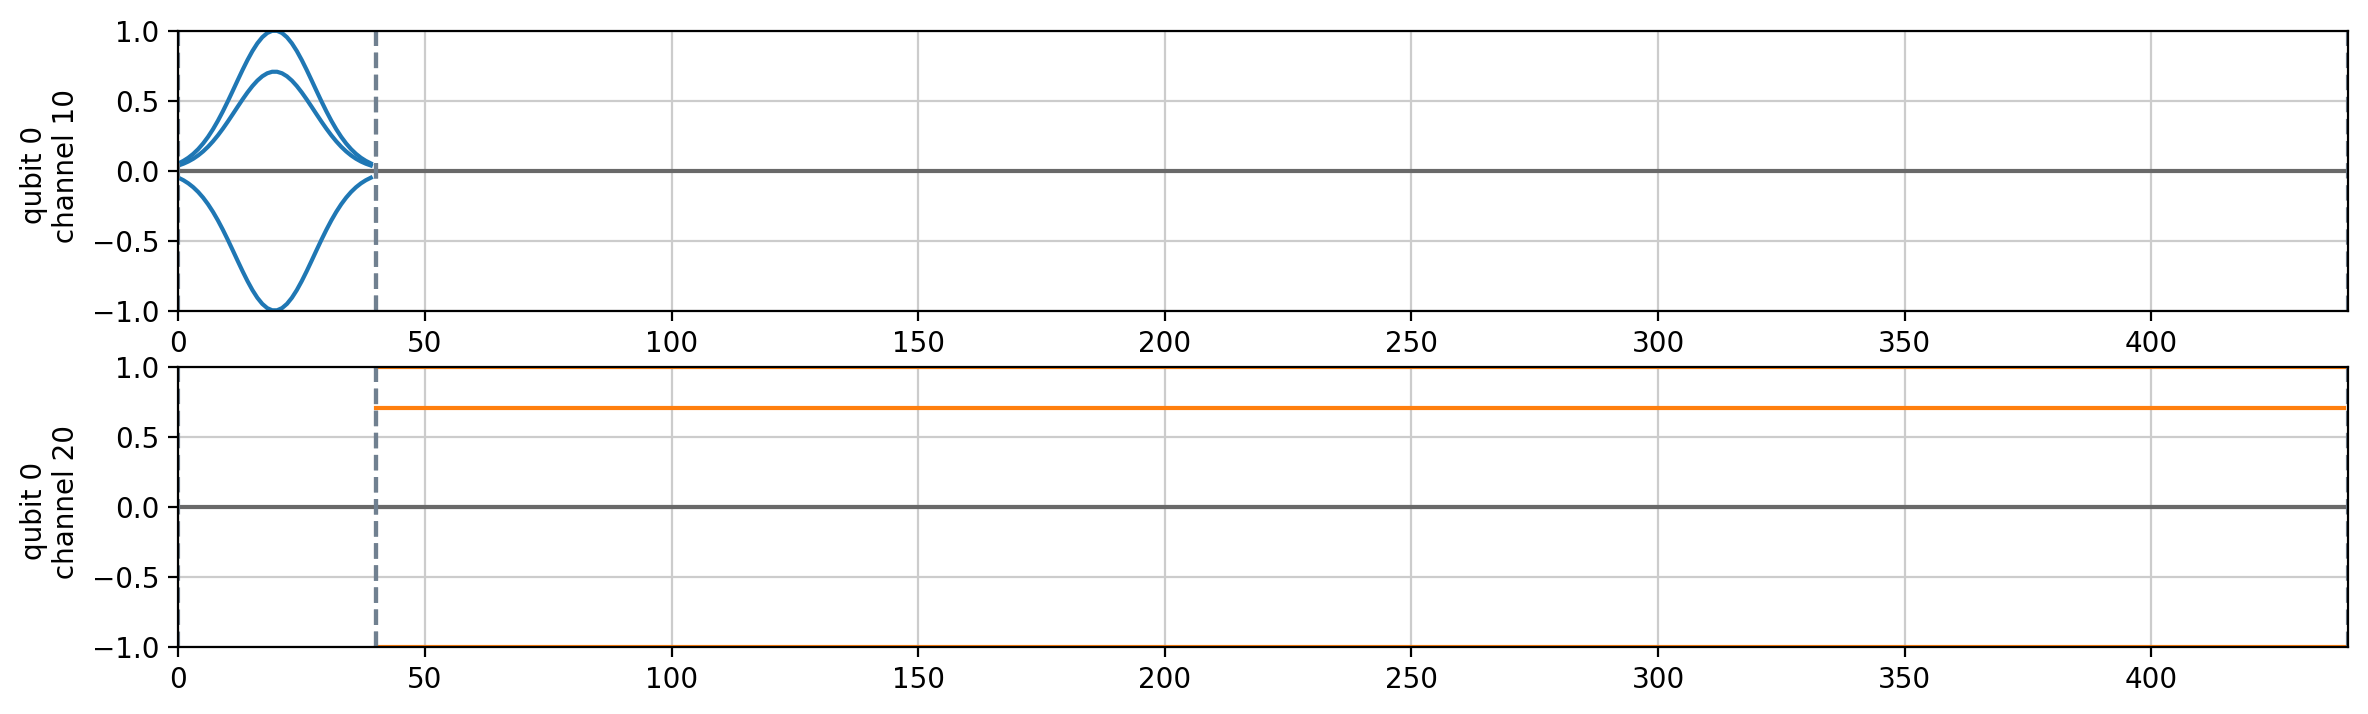

In [1]:
from qibolab.pulses import Pulse, ReadoutPulse, DrivePulse, FluxPulse
from qibolab.pulses import PulseShape, Rectangular, Gaussian, Drag, IIR, SNZ, eCap, Waveform

p0 = DrivePulse(start=0, 
                duration=40, 
                amplitude=1, 
                frequency=200e6, 
                relative_phase=0, 
                shape=Gaussian(5), 
                channel=10, 
                qubit=0)

p1 = ReadoutPulse(start=p0.duration,
                  duration=400,
                  amplitude=1, 
                  frequency=20e6, 
                  relative_phase=0,
                  shape=Rectangular(),
                  channel=20, 
                  qubit=0)
ps = p0 + p1
ps.plot()

If one of those variables change, the pulses that use them change automatically:

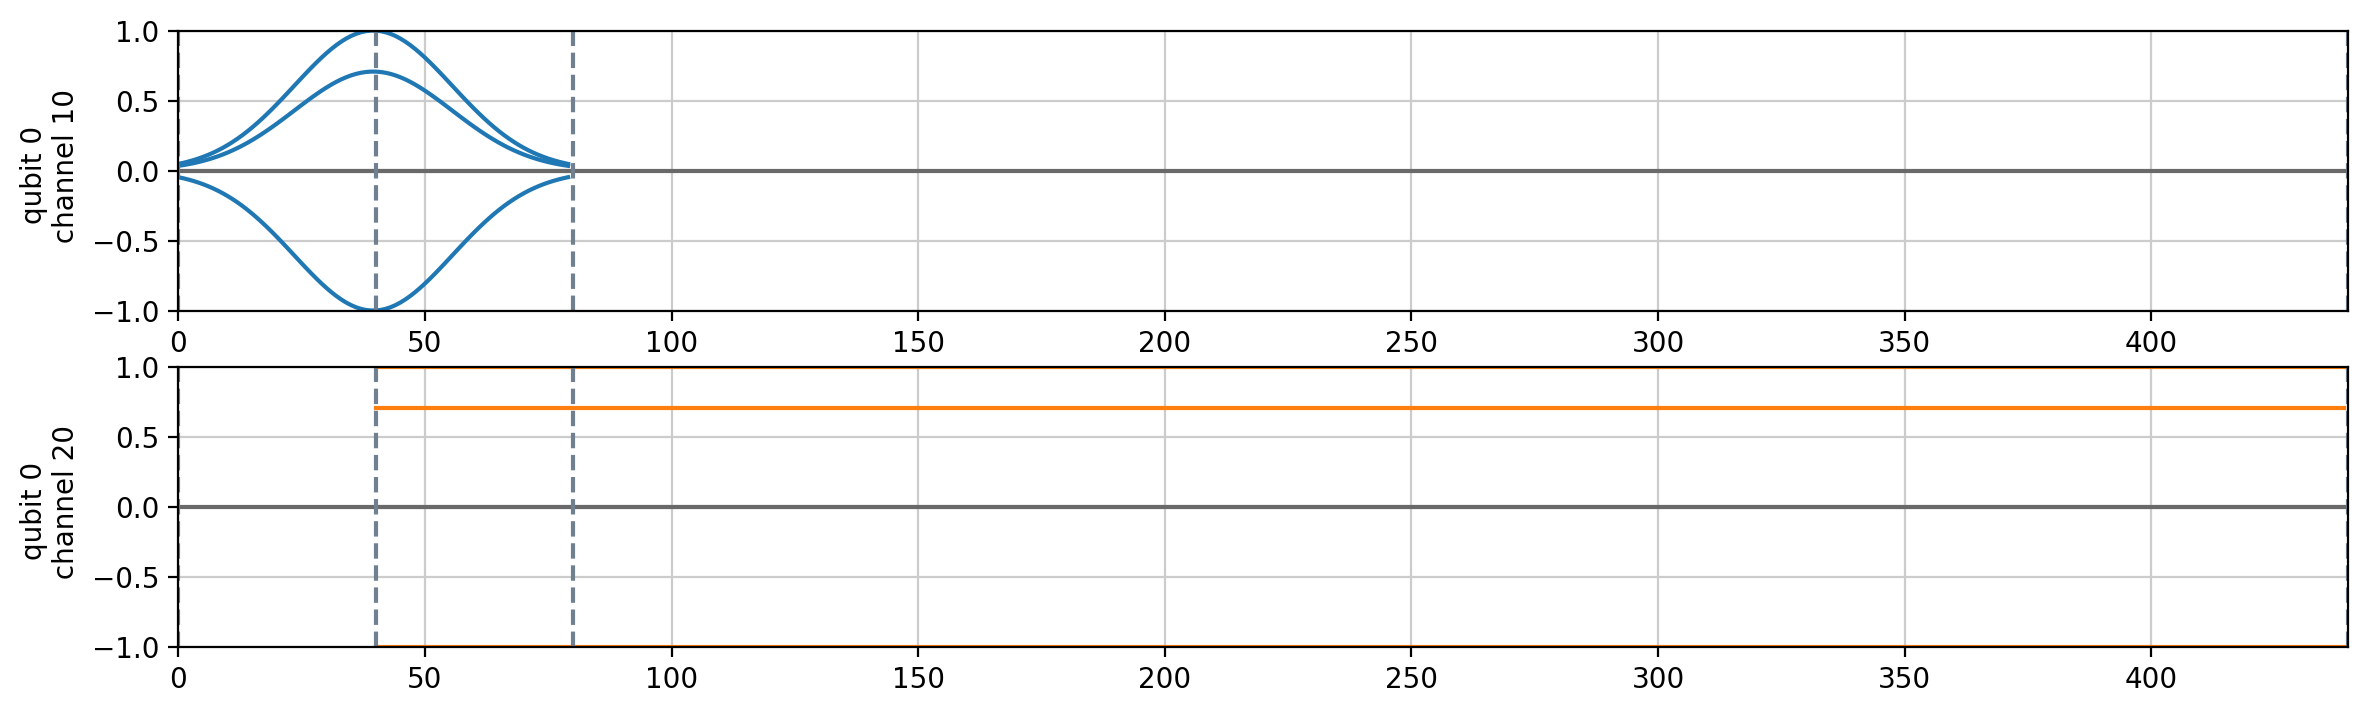

In [2]:
p0.duration = 80
ps.plot()

or

#### Initialisation

The main changes in the initialization of Pulse are those related to the changes in the attributes: 
```python
def __init__(self, start: int, duration: int, amplitude: float, 
                   frequency: int, relative_phase: float, shape: PulseShape | str,
                   channel: int | str, type: PulseType | str  = PulseType.DRIVE, qubit: int | str = 0):
``` 
The argument `phase` was replaced with `relative_phase`, the `shape` argument continues to support `PulseShape` objects or strings. `channel`and `qubit` support both integers or strings, and finally, the `type` argument supports a string or a constant from PulseType enumeration:
```python
class PulseType(Enum):
    READOUT = "ro"
    DRIVE = "qd"
    FLUX = "qf"
```

Pulse `type` and `qubit` are optional arguments, and default to `PulseType.DRIVE` and `0` respectively.

Below are some examples of Pulse initialization:

In [3]:
from qibolab.pulses import Pulse, ReadoutPulse, DrivePulse, FluxPulse
from qibolab.pulses import PulseShape, Rectangular, Gaussian, Drag
from qibolab.pulses import PulseType, PulseSequence, SplitPulse
import numpy as np

In [4]:
# standard initialisation
p0 = Pulse(start = 0, 
        duration = 50, 
        amplitude = 0.9, 
        frequency = 20_000_000, 
        relative_phase = 0.0, 
        shape = Rectangular(), 
        channel = 0, 
        type = PulseType.READOUT, 
        qubit = 0)

In [5]:
# initialisation with str shape
p4 = Pulse(start = 0, 
        duration = 50, 
        amplitude = 0.9, 
        frequency = 20_000_000, 
        relative_phase = 0, 
        shape = 'Rectangular()', 
        channel = 0, 
        type = PulseType.READOUT, 
        qubit = 0)

In [6]:
# initialisation with str channel and str qubit
p5 = Pulse(start = 0, 
        duration = 50, 
        amplitude = 0.9, 
        frequency = 20_000_000, 
        relative_phase = 0, 
        shape = 'Rectangular()', 
        channel = 'channel0', 
        type = PulseType.READOUT, 
        qubit = 0)
assert p5.qubit == 0

In [7]:
# examples of initialisation with different frequencies, shapes and types
p6 = Pulse(0, 40, 0.9, -50e6, 0, Rectangular(), 0, PulseType.READOUT)
p7 = Pulse(0, 40, 0.9, 0, 0, Rectangular(), 0, PulseType.FLUX, 0)
p8 = Pulse(0, 40, 0.9, 50e6, 0, Gaussian(5), 0, PulseType.DRIVE, 2)
p9 = Pulse(0, 40, 0.9, 50e6, 0, Drag(5,2), 0, PulseType.DRIVE, 200)

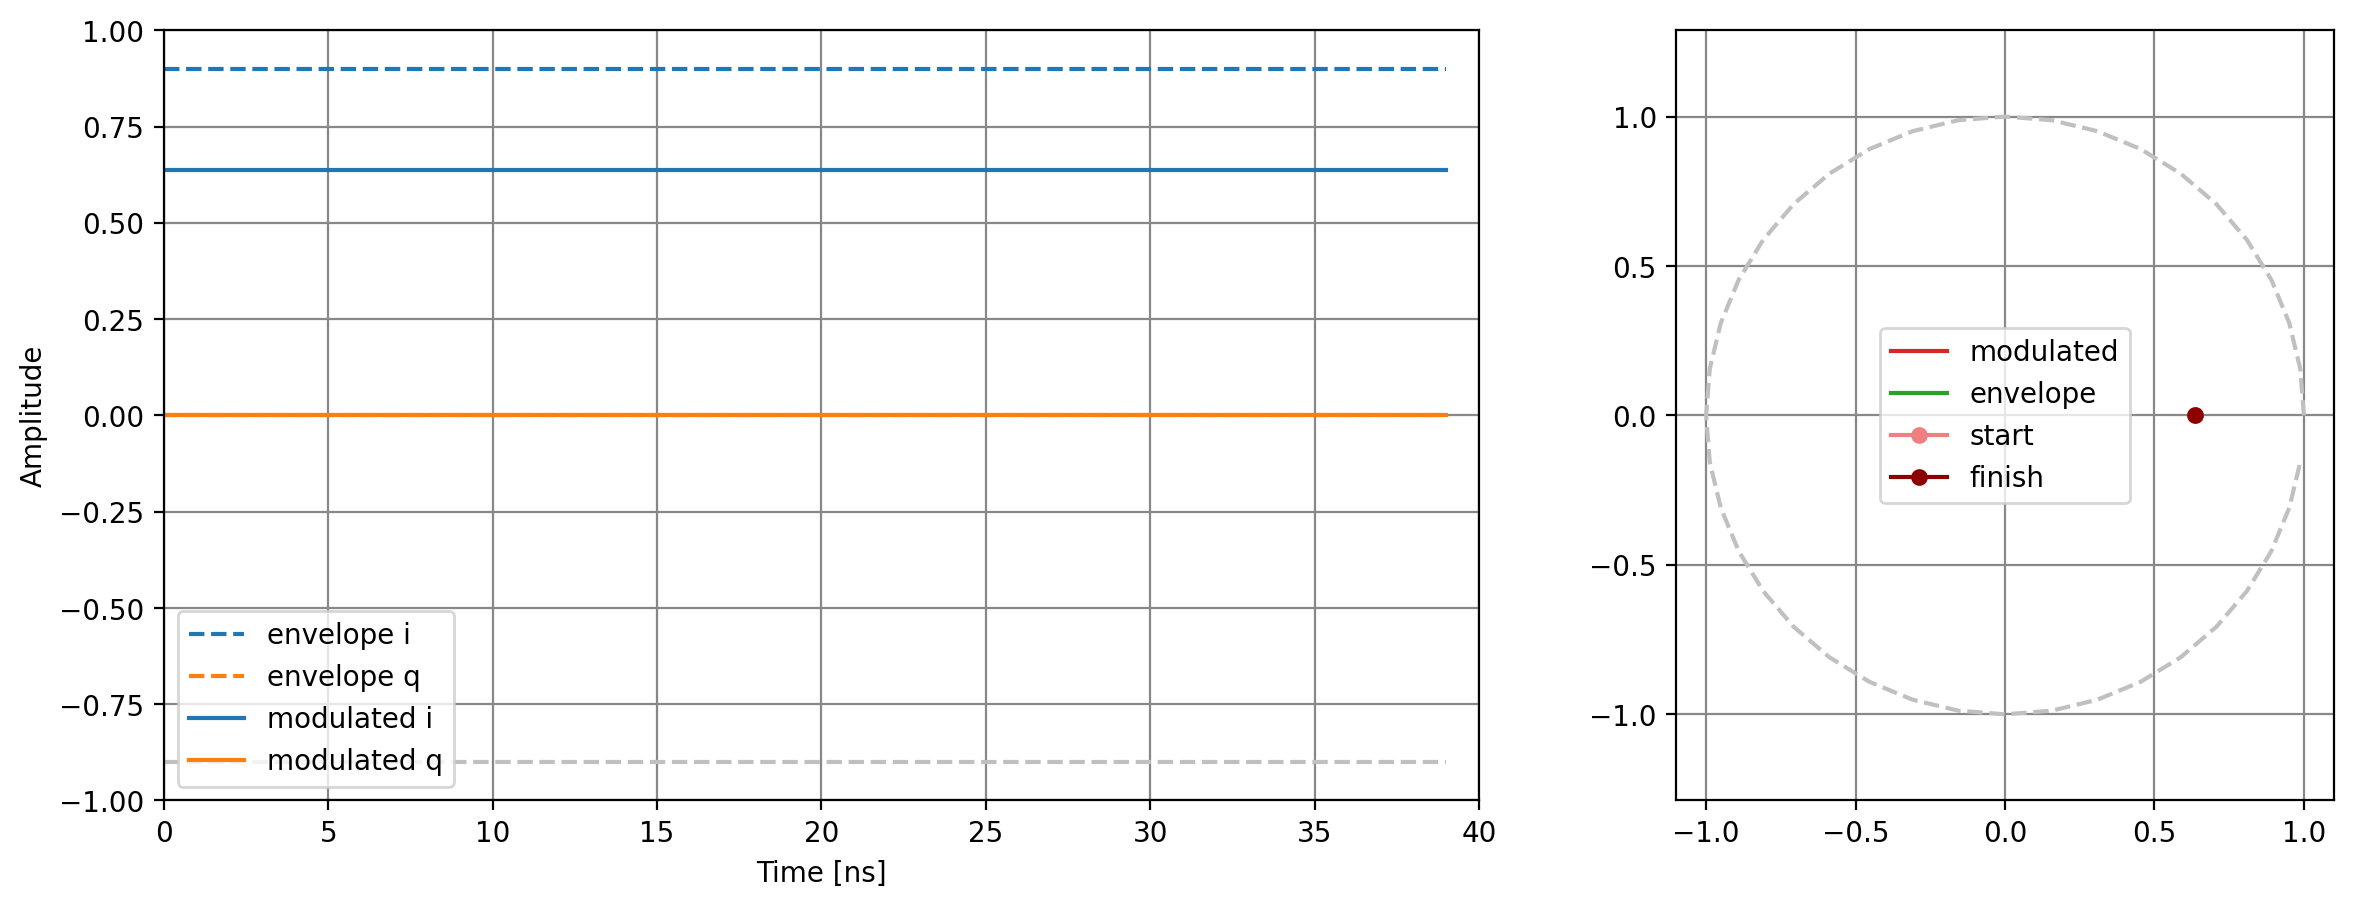

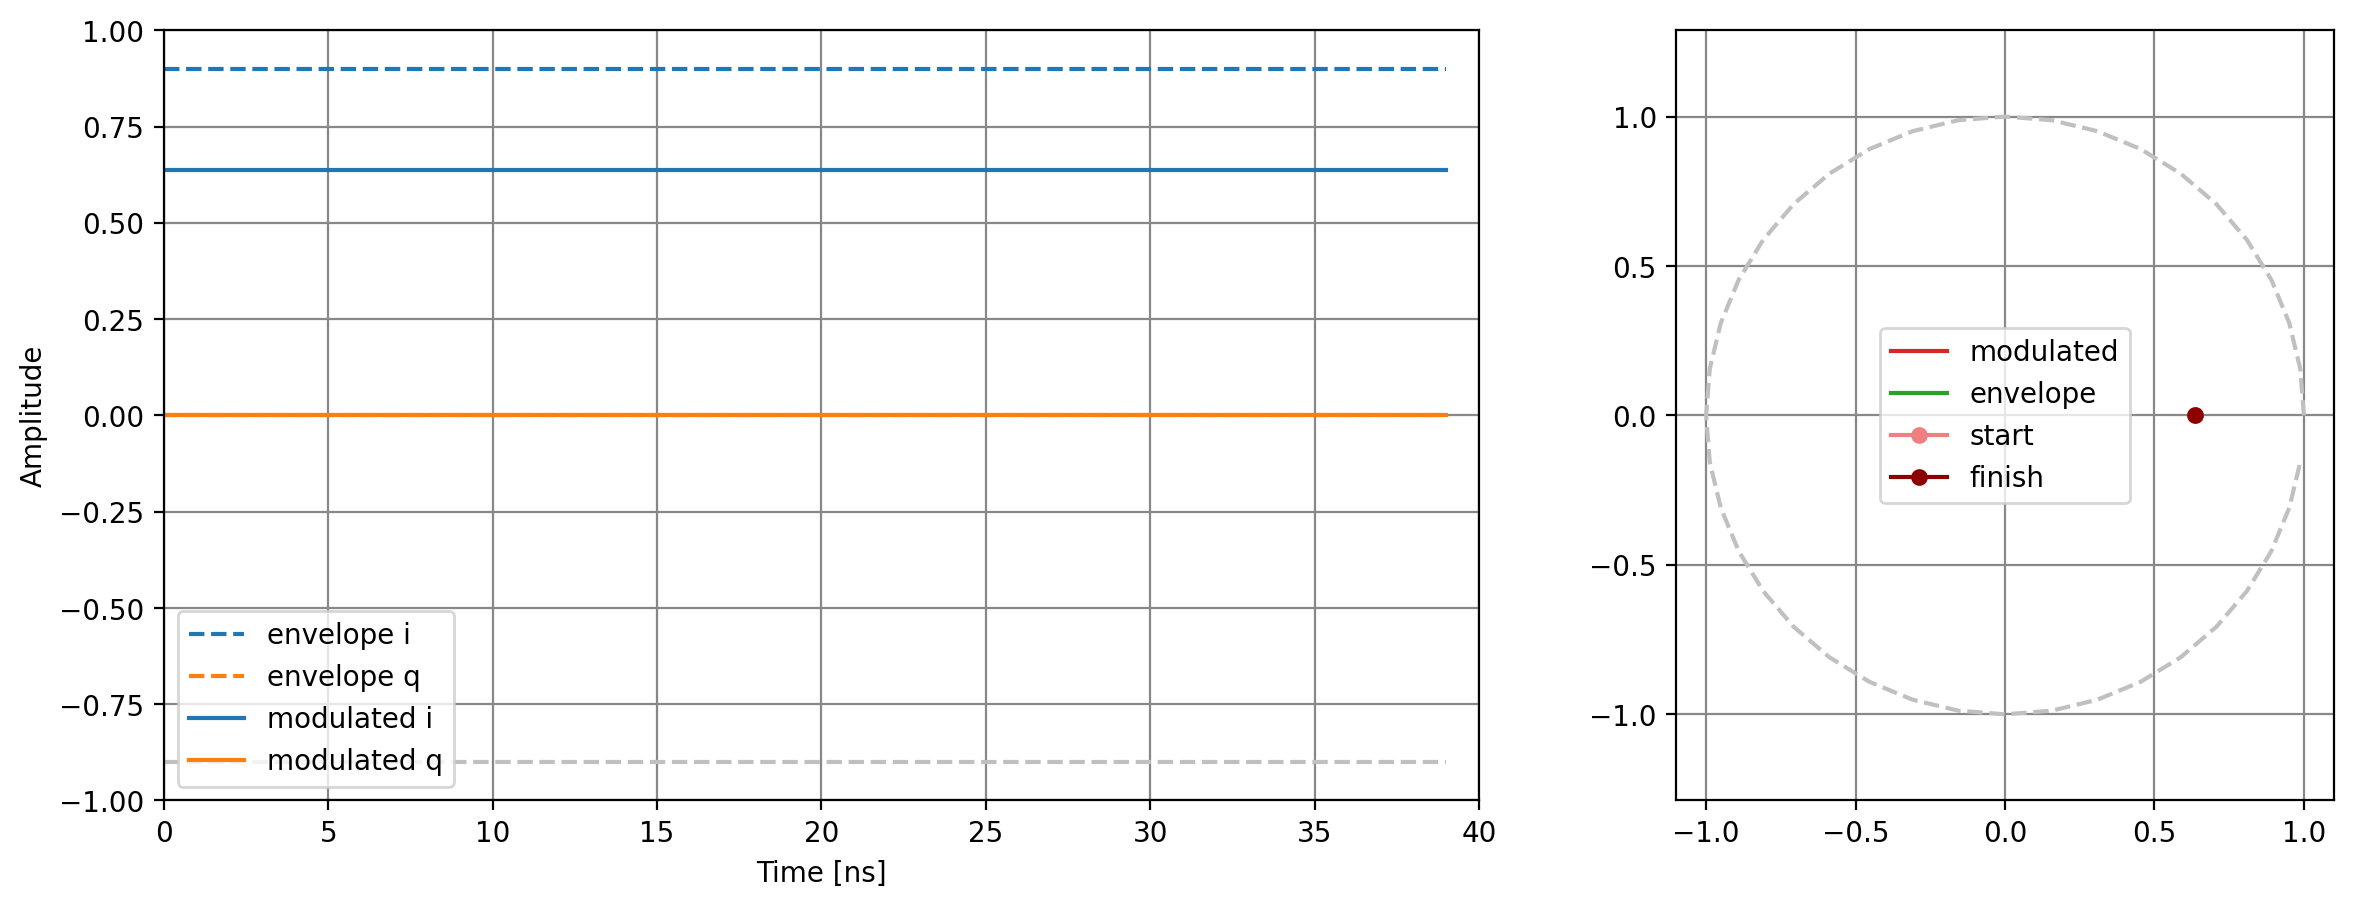

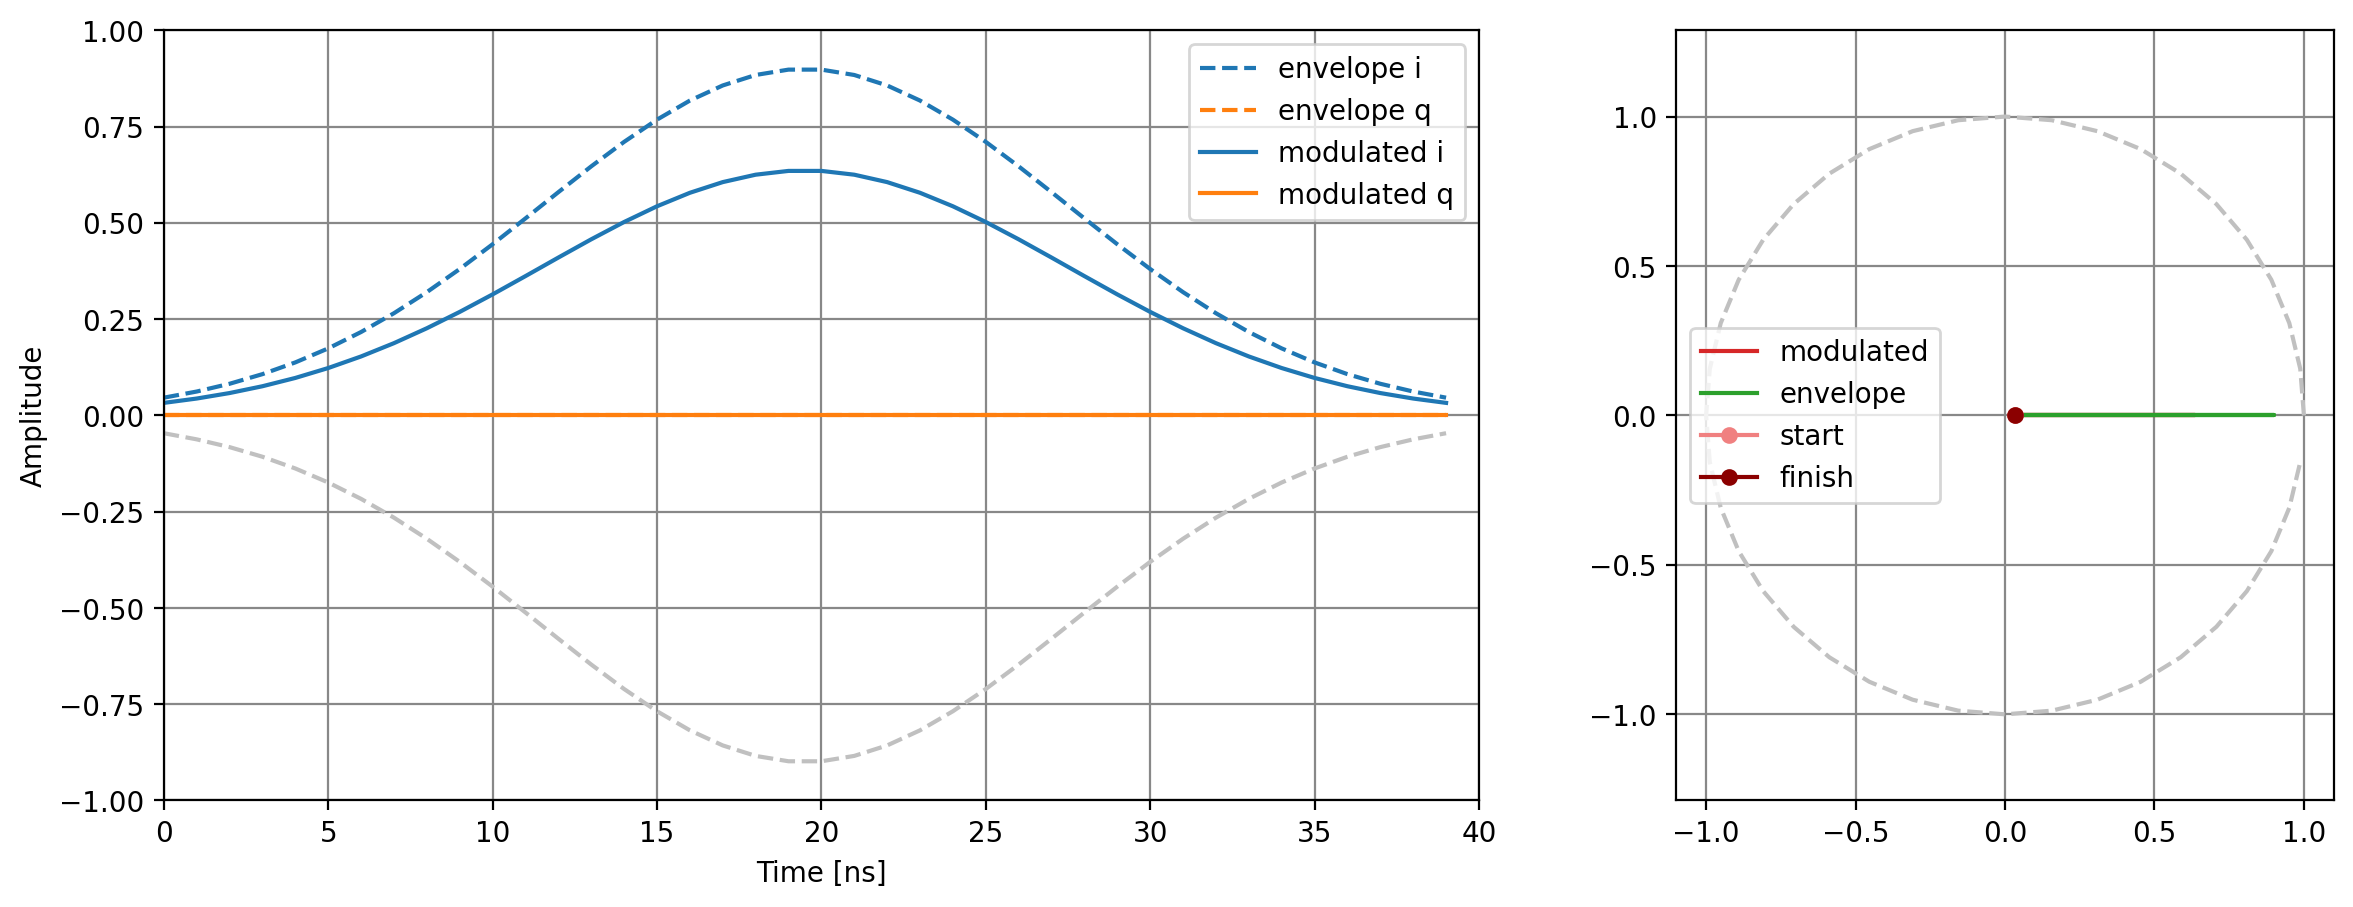

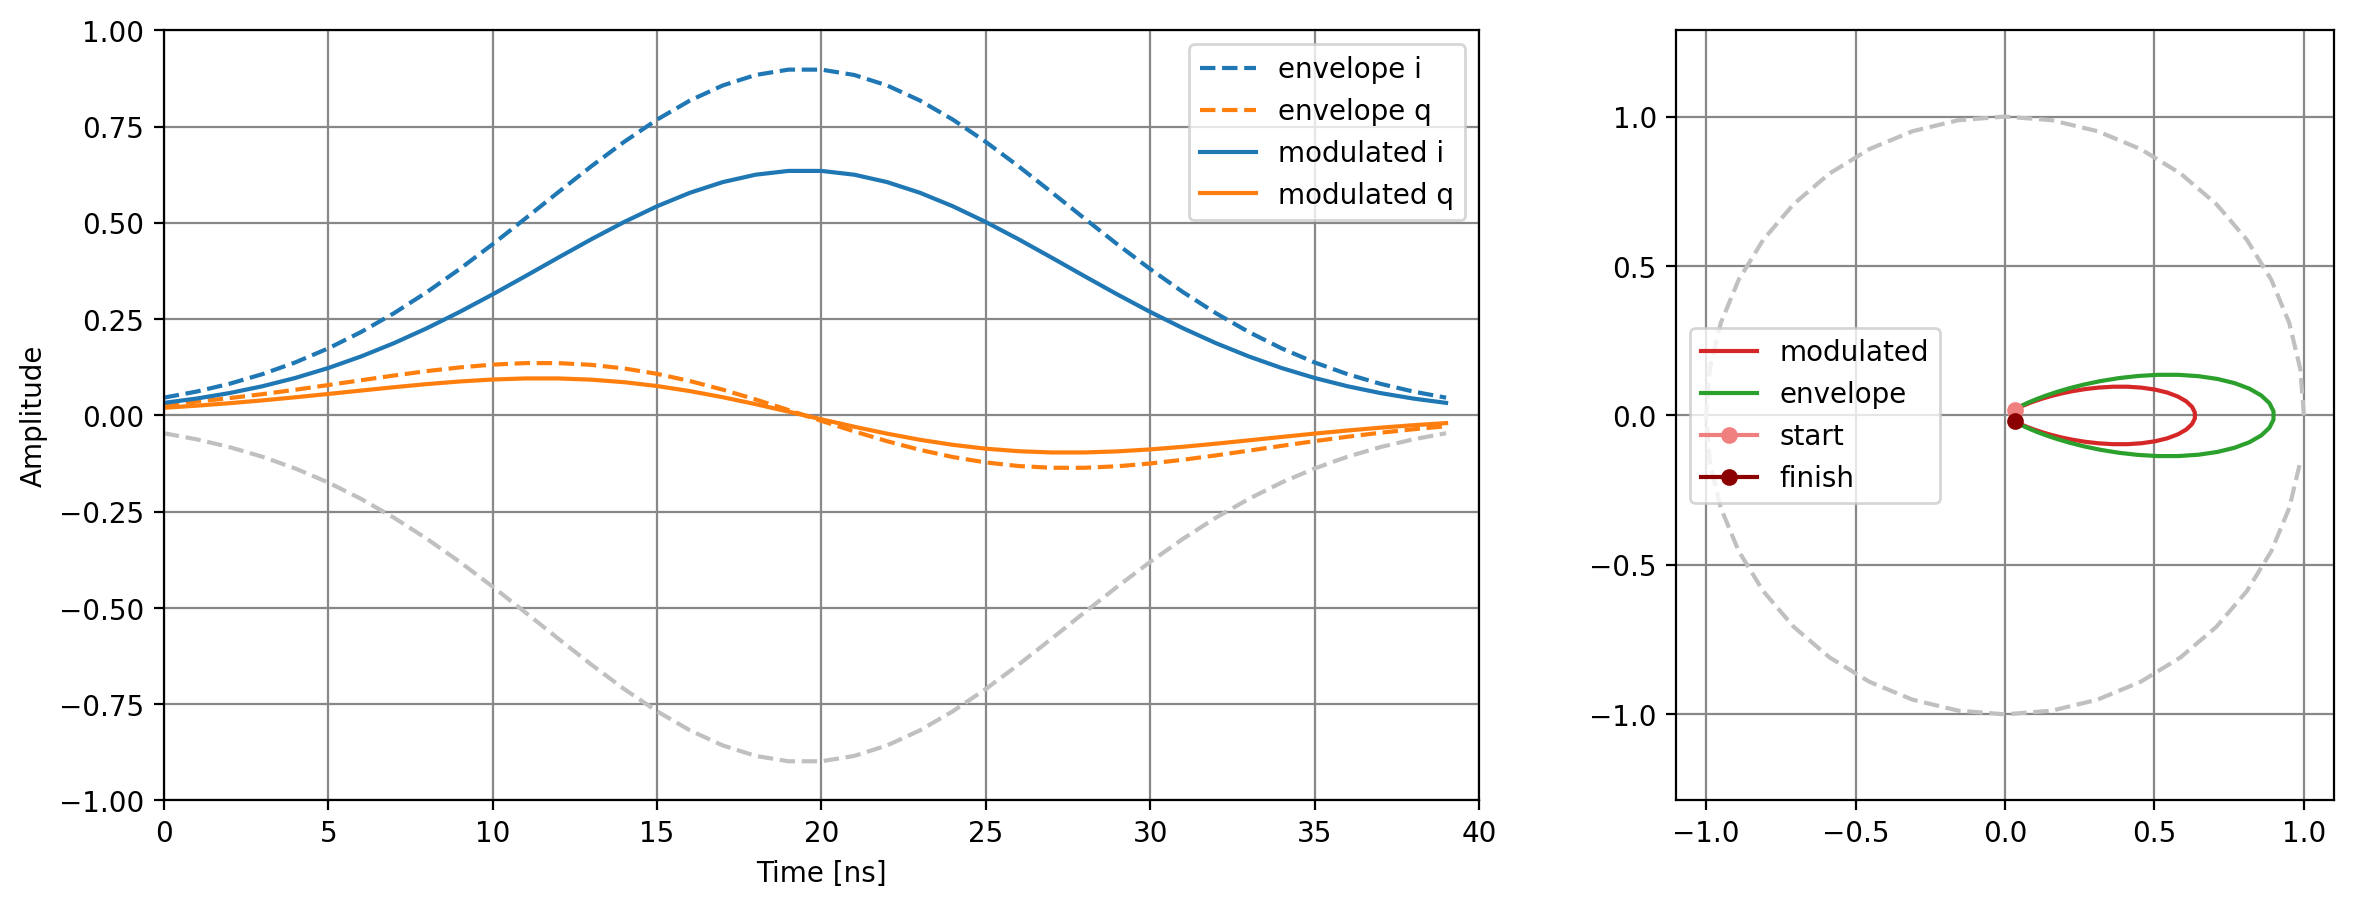

In [8]:
p6.plot()
p7.plot()
p8.plot()
p9.plot()

#### Attributes

Pulse implements these attributes:
- `start`
- `duration`
- `finish` (read only)
- `amplitude`
- `frequency`
- `relative_phase`
- `phase` (read only) returns the total phase of the pulse (global, based on its start + relative)
- `shape` a `PulseShape` object
- `channel`
- `type`
- `qubit`
- `serial` a str representation of the object
- `envelope_waveform_i` a Waveform object
- `envelope_waveform_q` a Waveform object
- `envelope_waveforms` a tuple of (Waveform, Waveform)
- `modulated_waveform_i` a Waveform object
- `modulated_waveform_q` a Waveform object
- `modulated_waveforms` a tuple of (Waveform, Waveform)

#### Methods

#### Operators

Pulse now supports a small set of operators (`==`, `!=`, `+`, `*`).
Pulse is hashable, but not unmutable (its hash depends on the current value of its parameters), so one can use the following operators to compare pulses:

In [10]:
p0 = Pulse(0, 40, 1, 100e6, 0, Rectangular(), 0, PulseType.DRIVE, 0)
p1 = Pulse(100, 40, 1, 100e6, 0, Rectangular(), 0, PulseType.DRIVE, 0)
p2 = Pulse(0, 40, 1, 100e6, 0, Rectangular(), 0, PulseType.DRIVE, 0)

assert p0 != p1
assert p0 == p2

# If we change p1 start to 0 it become the same as p0
p1.start = 0
assert p0 == p1

Since it is hashable, it can also be used as keys of a dictionary:

In [11]:
rp = Pulse(0, 40, 0.9, 100e6, 0, Rectangular(), 0, PulseType.DRIVE)
dp = Pulse(0, 40, 0.9, 100e6, 0, Drag(5,1), 0, PulseType.DRIVE)
hash(rp)
my_dict = {rp: 1, dp: 2}
assert list(my_dict.keys())[0] == rp
assert list(my_dict.keys())[1] == dp

Adding two Pulses returns a PulseSequence. Multiplying a Pulse by an integer n returns a PulseSequence with n deep copies of the original pulse.

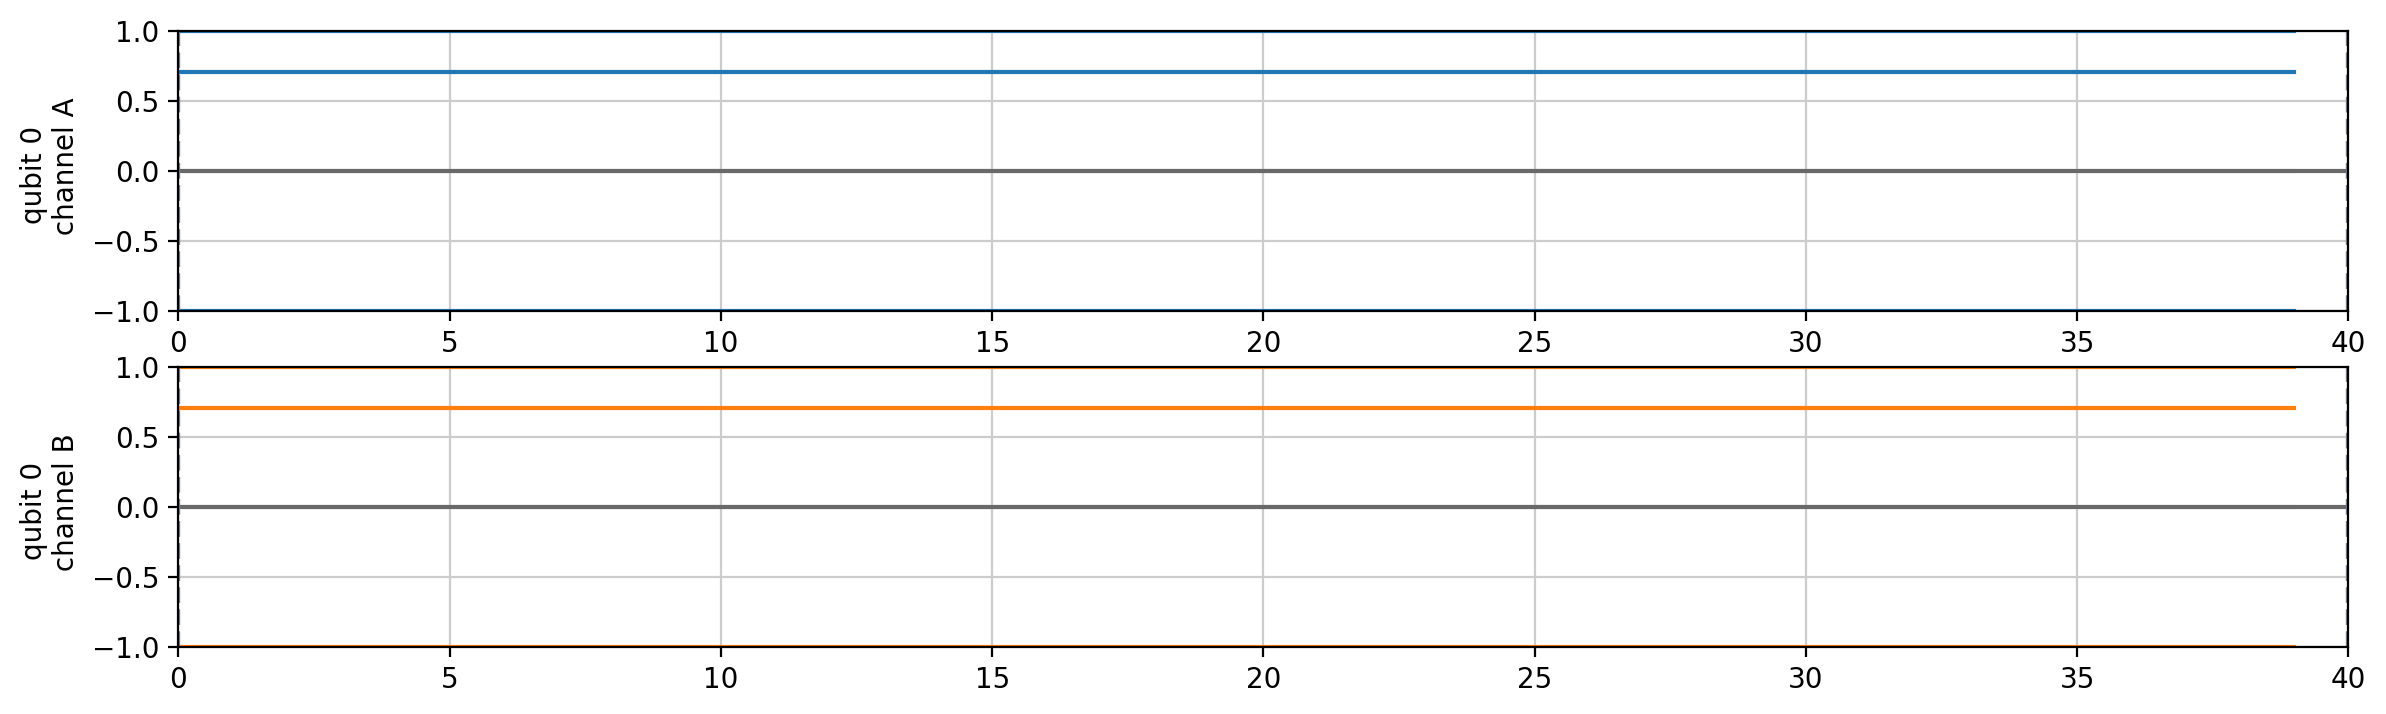

In [12]:
pA = Pulse(0, 40, 1, 100e6, 0, Rectangular(), 'A', PulseType.DRIVE, 0)
pB = Pulse(0, 40, 1, 100e6, 0, Rectangular(), 'B', PulseType.DRIVE, 0)
ps = pA + pB
assert type(ps) == PulseSequence
ps.plot()

As we have already seen, Pulse also implements a `plot()` method that represents the pulse waveforms:

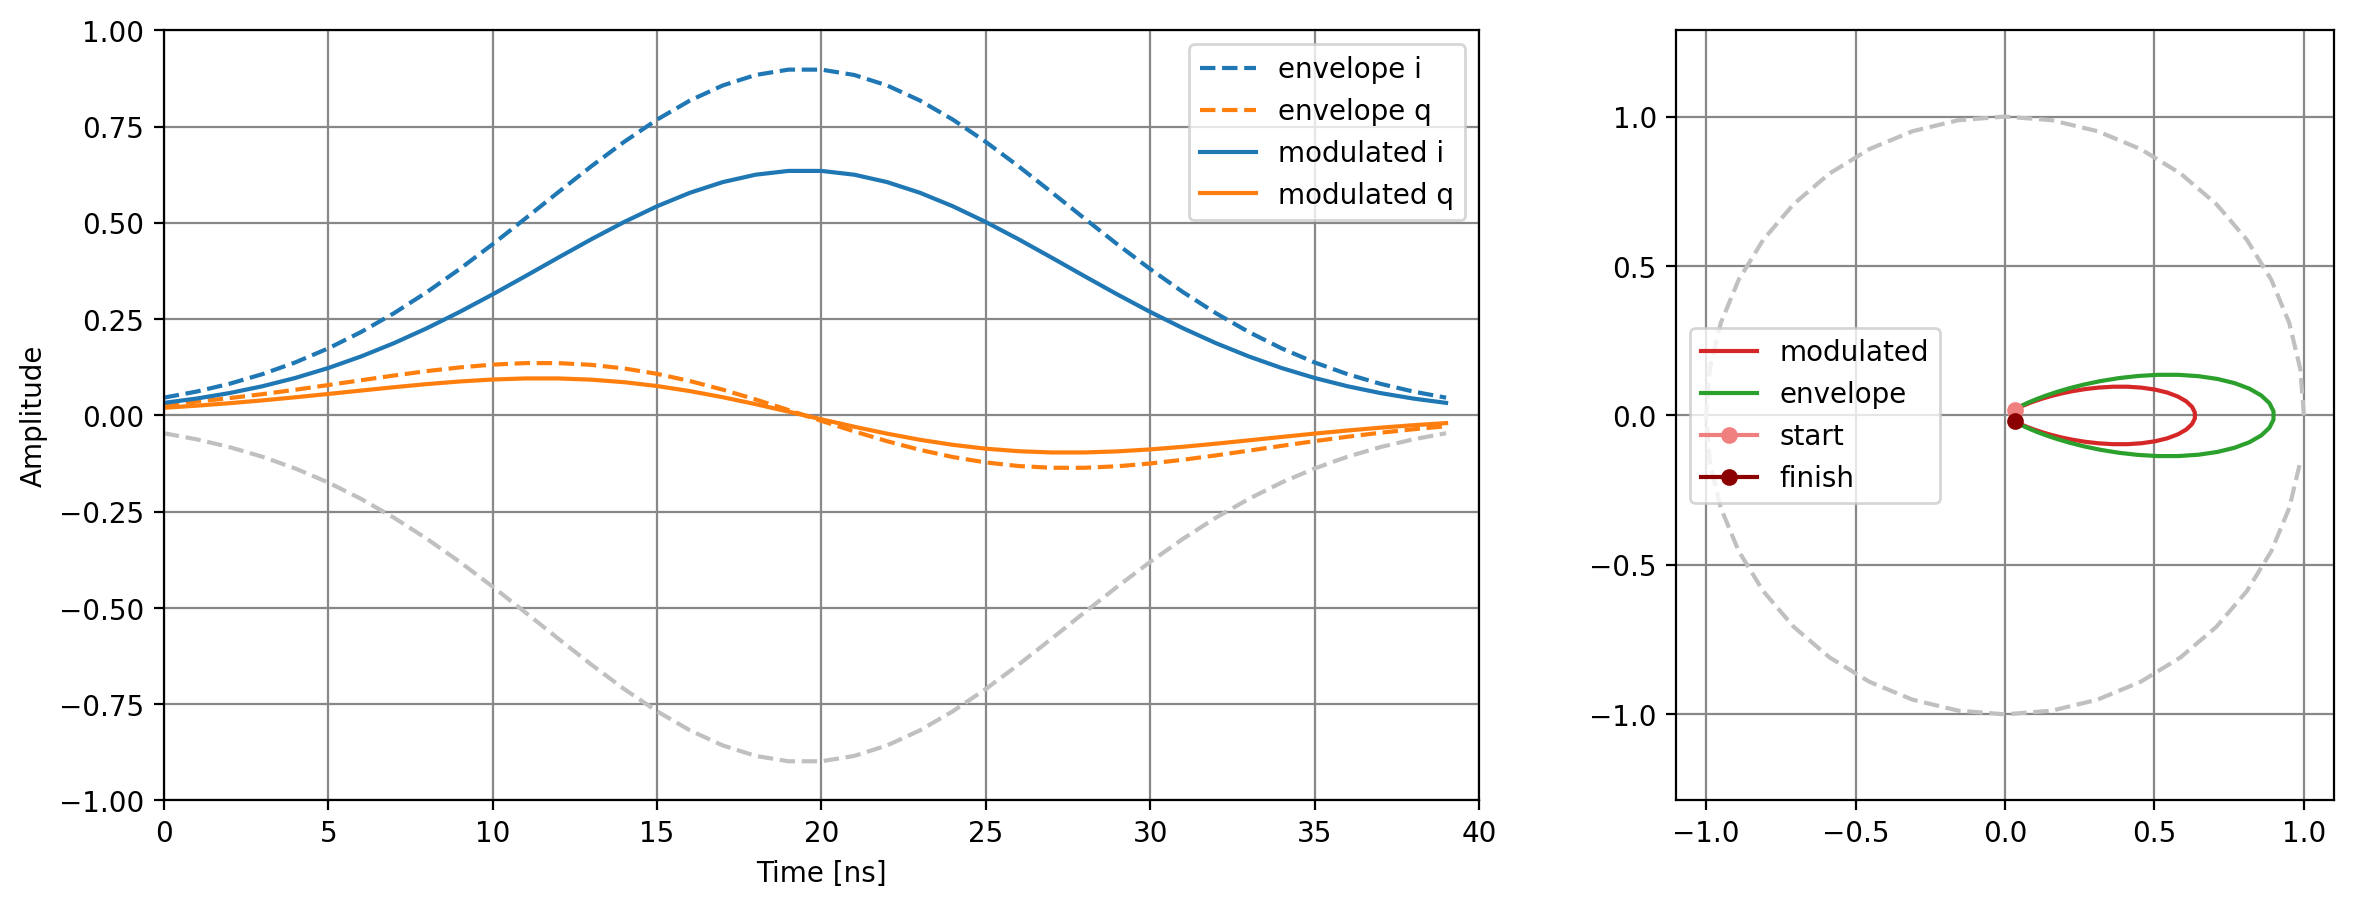

In [13]:
drag_pulse = Pulse(0, 40, 0.9, 50e6, 0, Drag(5,2), 0, PulseType.DRIVE, 200)
drag_pulse.plot()

#### ReadoutPulse, DrivePulse & FluxPulse Aliases

These objects are subclasses of the Pulse object. They have a different representation, and in their instantiation one does not require to specify the type.

In [14]:
rop = ReadoutPulse(start = 0,
            duration = 50, 
            amplitude = 0.9, 
            frequency = 20_000_000, 
            relative_phase = 0.0, 
            shape = Rectangular(), 
            channel = 0, 
            qubit = 0)
assert isinstance(rop, Pulse)

dp = DrivePulse(start = 0,
            duration = 2000, 
            amplitude = 0.9, 
            frequency = 200_000_000, 
            relative_phase = 0.0, 
            shape = Gaussian(5), 
            channel = 0, 
            qubit = 0)
assert isinstance(rop, Pulse)

fp = FluxPulse(start = 0,
            duration = 300, 
            amplitude = 0.9, 
            shape = Rectangular(), 
            channel = 0, 
            qubit = 0)

assert isinstance(rop, Pulse)

#### SplitPulse

Sometimes the length of the pulse is so long that it doesn't fit in the memory of one sequencer. In that case it needs to be played by two (or more) sequencers.
The `SplitPulse` class was introduced to support splitting a long puse into smaller portions:

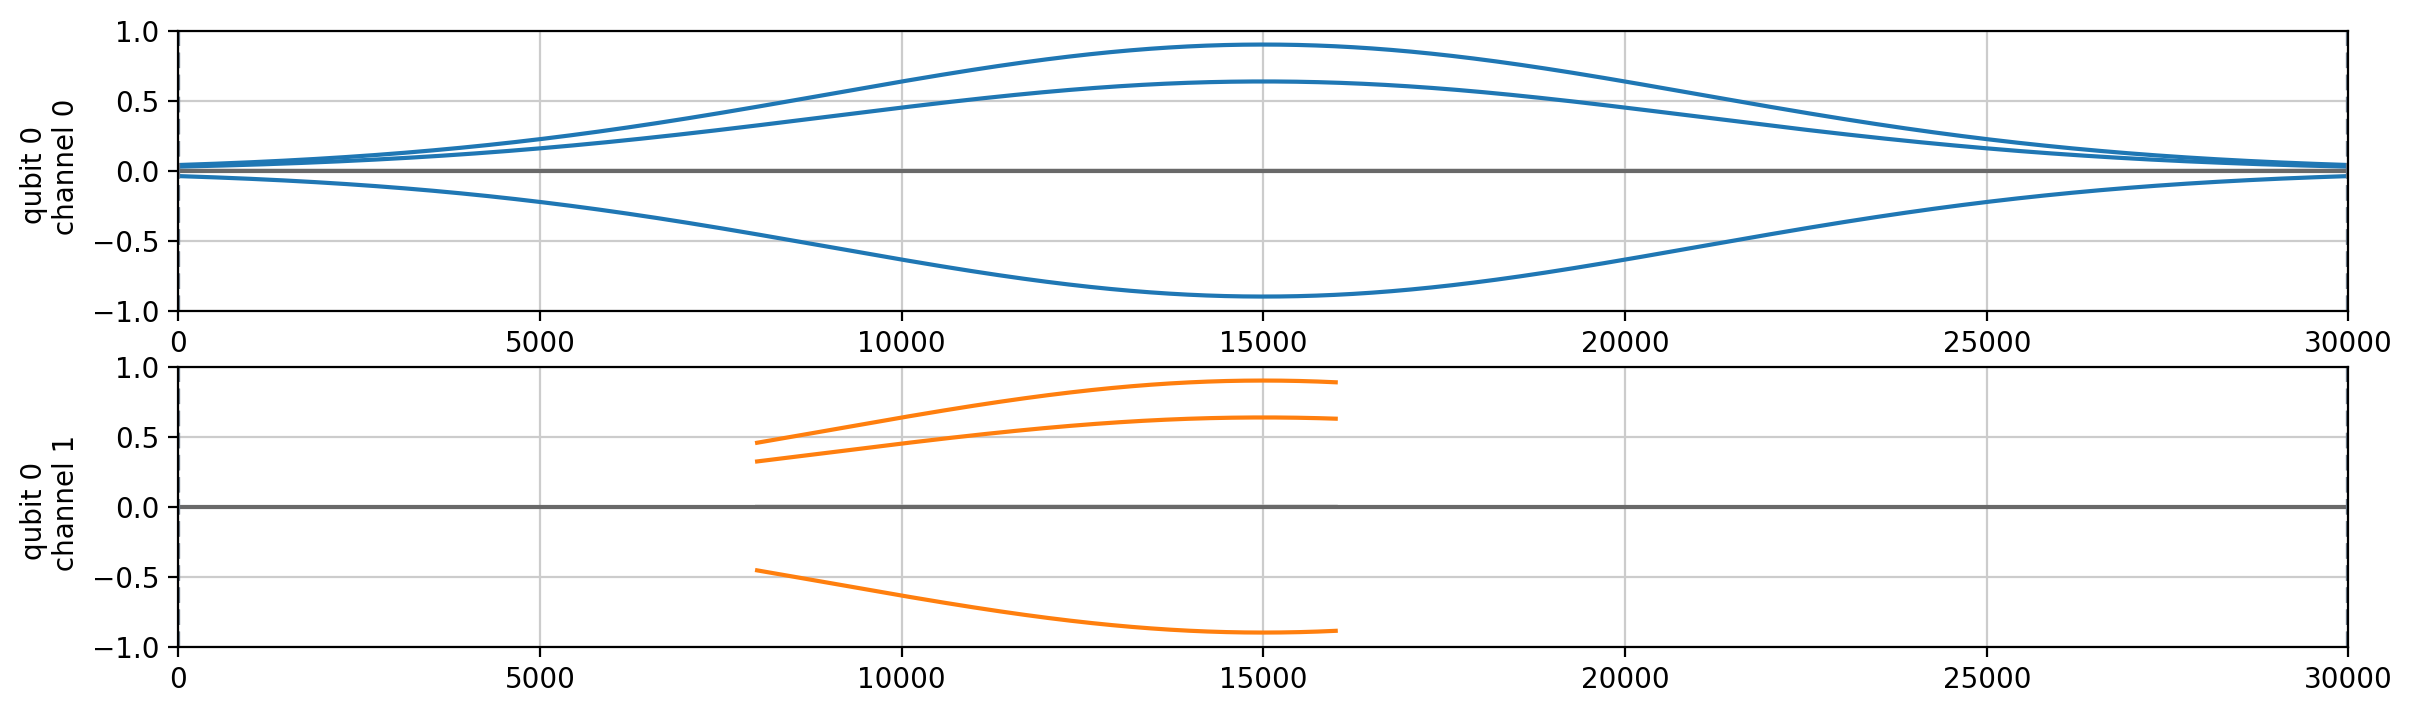

In [15]:
dp = Pulse(start = 0,
            duration = 30000, 
            amplitude = 0.9, 
            frequency = 500_000, 
            relative_phase = 0.0, 
            shape = Gaussian(5), 
            channel = 0, 
            type = PulseType.READOUT,
            qubit = 0)

sp = SplitPulse(dp)
sp.channel = 1
a = 8000
b = 16000
sp.window_start = sp.start + a
sp.window_finish = sp.start + b
assert sp.window_start == sp.start + a
assert sp.window_finish == sp.start + b
ps = PulseSequence(dp, sp)
ps.plot()
assert len(sp.envelope_waveform_i()) == b - a
assert len(sp.envelope_waveform_q()) == b - a
assert len(sp.modulated_waveform_i()) == b - a
assert len(sp.modulated_waveform_q()) == b - a

### PulseShape

#### Overview

`PulseShape` objects are used to represent the different shapes a pulse can take. These objects are responsible for generating the waveforms based on the parameters of the pulse and the sampling rate set in the `PulseShape` class attribute `SAMPLING_RATE`.
All `PulseShape` objects support the generation of waveforms with an arbitrary sampling rate. This will be useful for whenever we use instruments that use a sampling rate different than 1e9 Hz.
The types of pulse shapes currently supported are `Rectangular()`, `Gaussian`, `Drag`

#### Sampling Rate

In [16]:
p14 = Pulse(0, 40, 0.9, 100e6, 0, Drag(5,1), 0, PulseType.DRIVE)

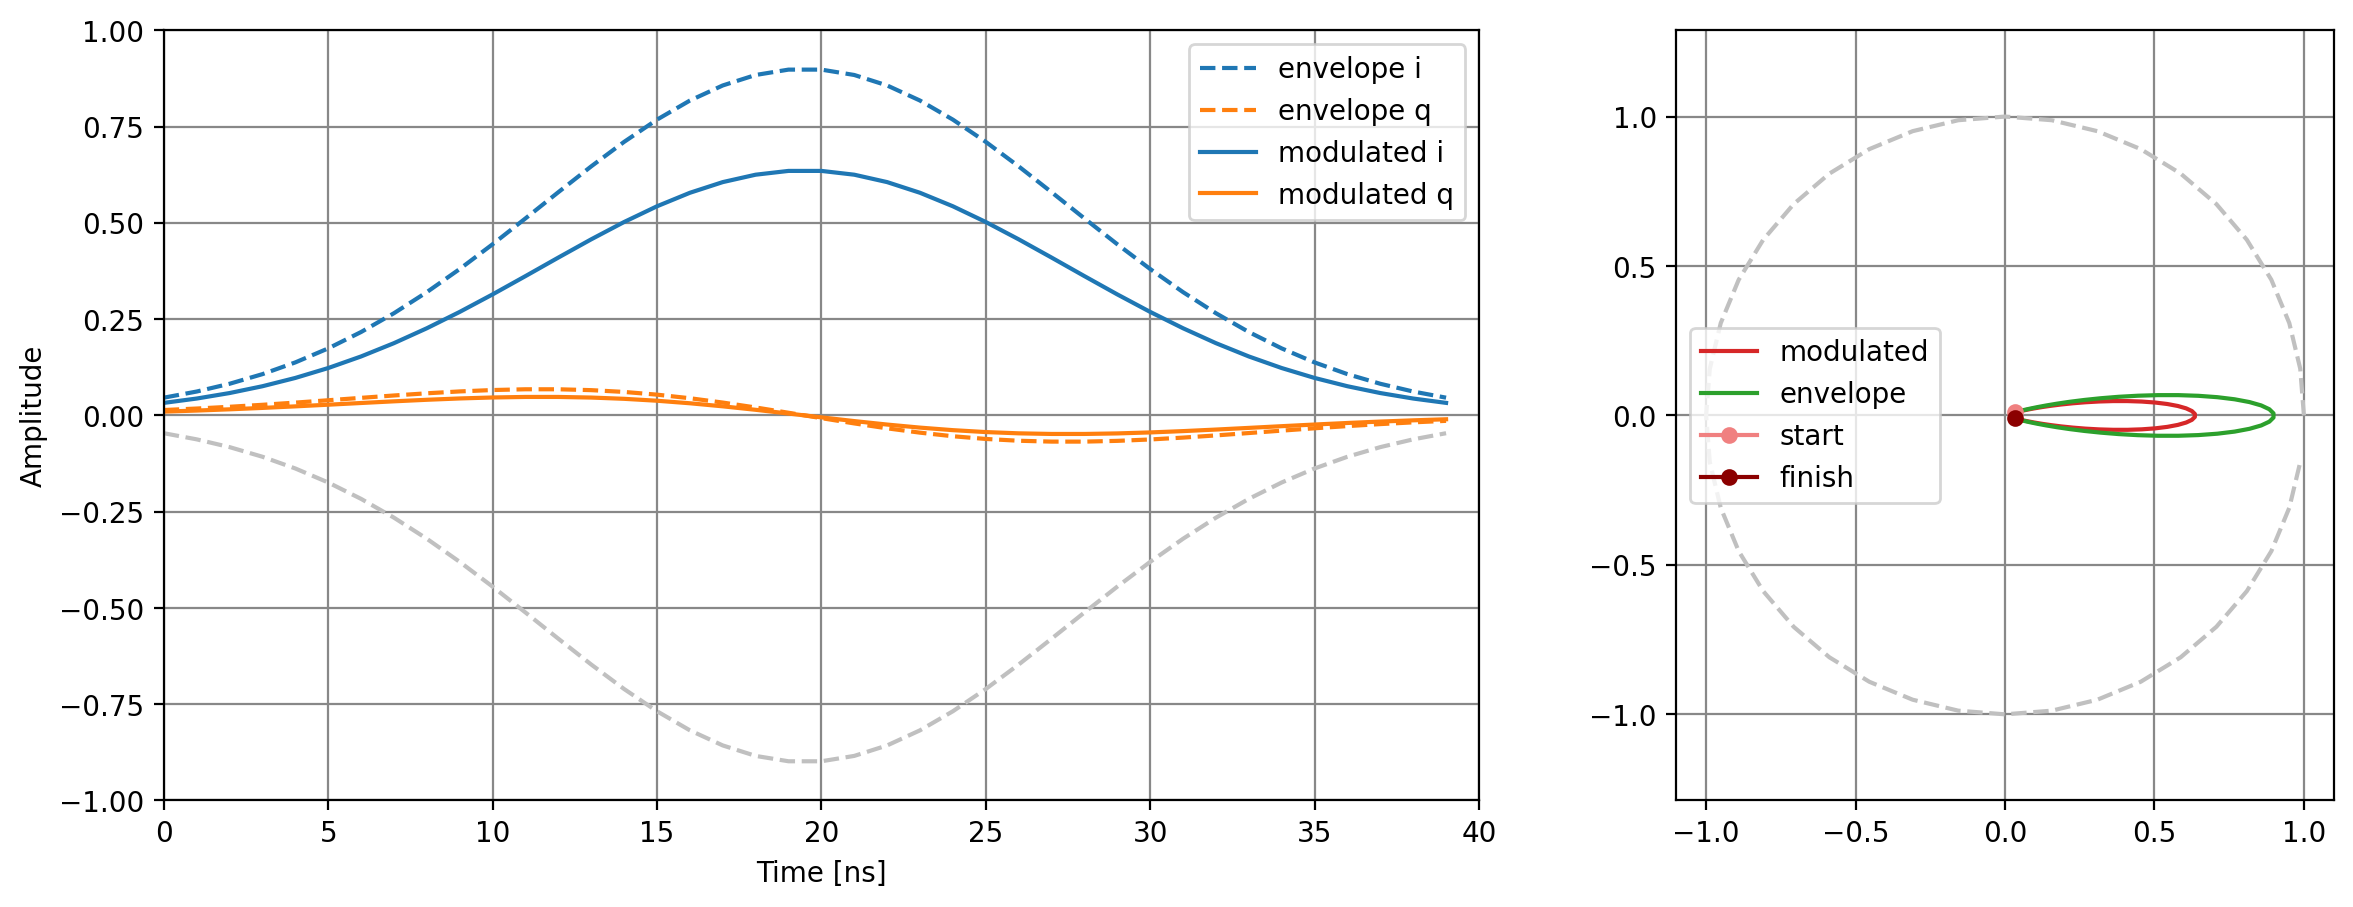

In [17]:
p14.plot(sampling_rate=1)

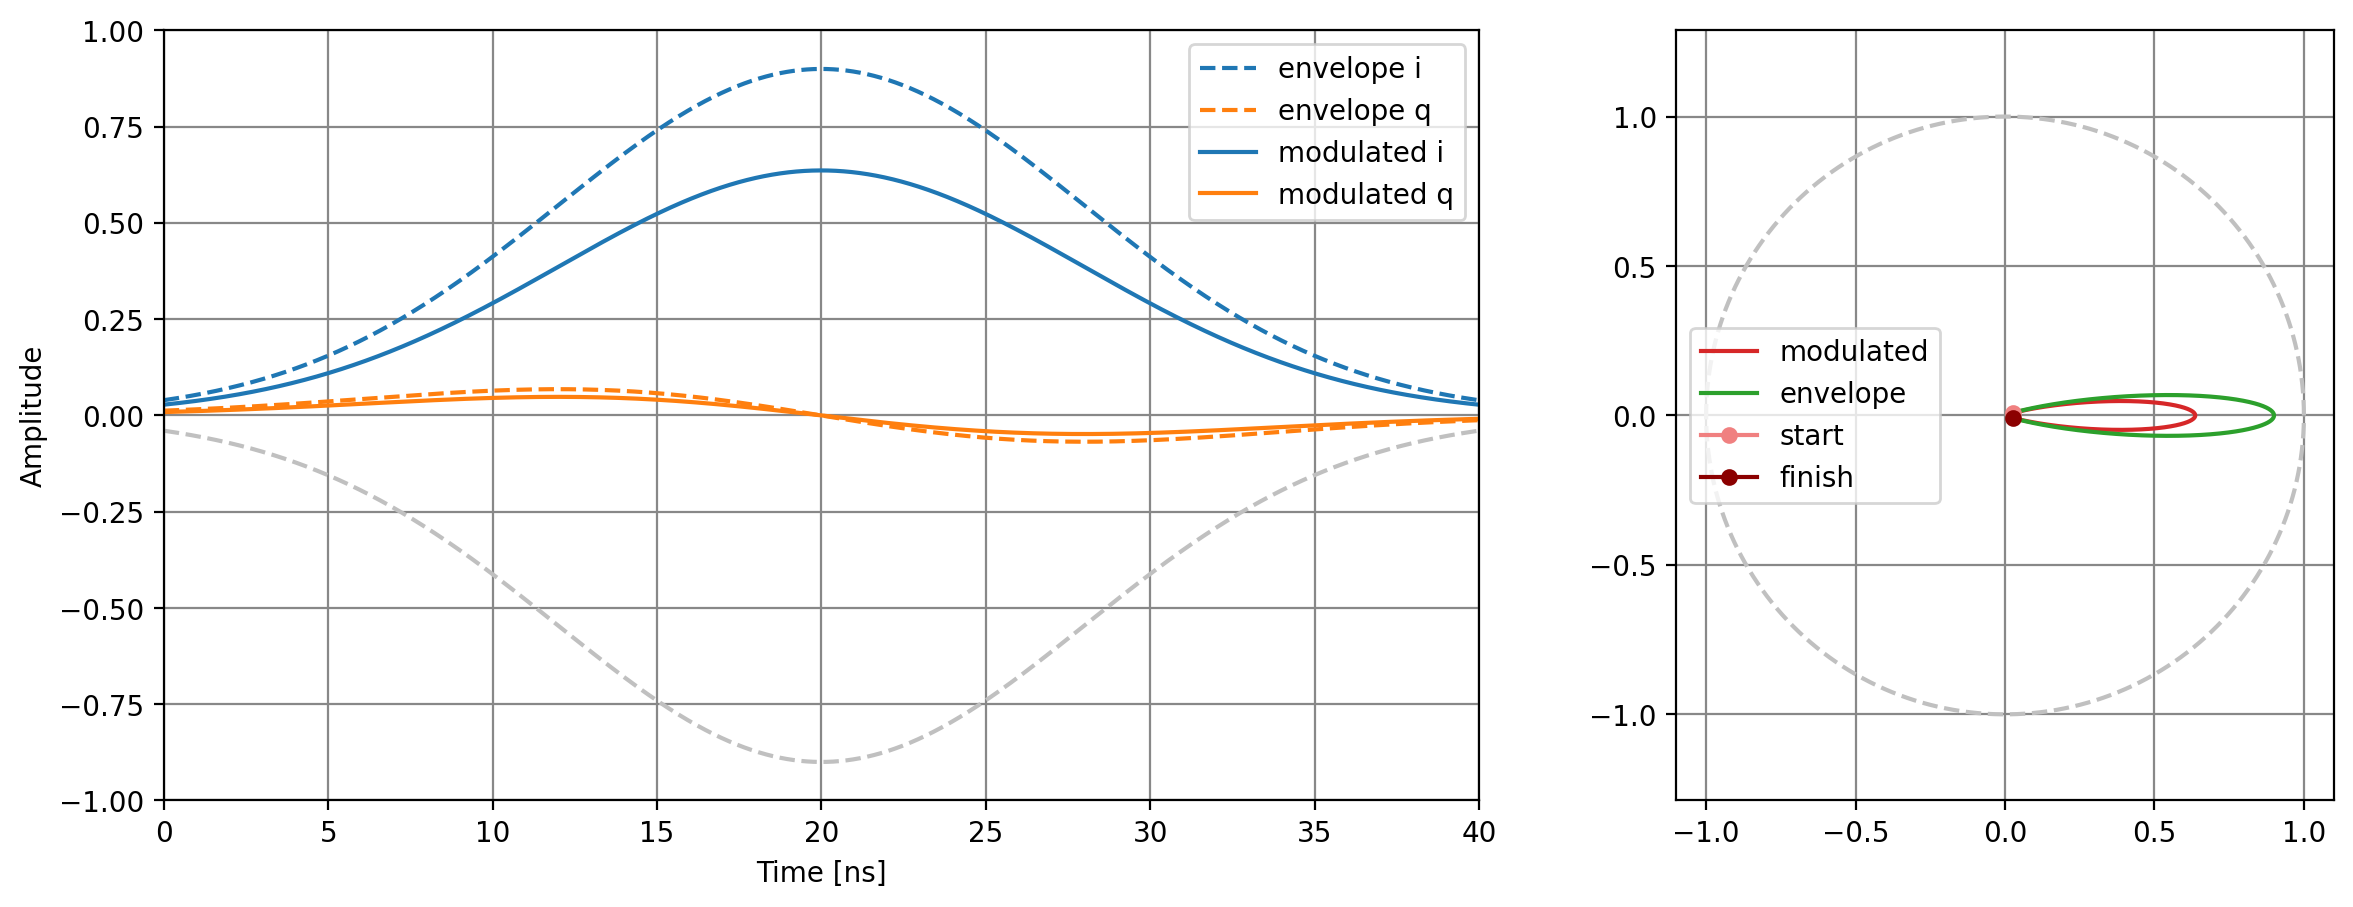

In [18]:
p14.plot(sampling_rate=100)

#### Drag Shape

This version of the driver includes a fix to the formula that generates the DRAG pulse.

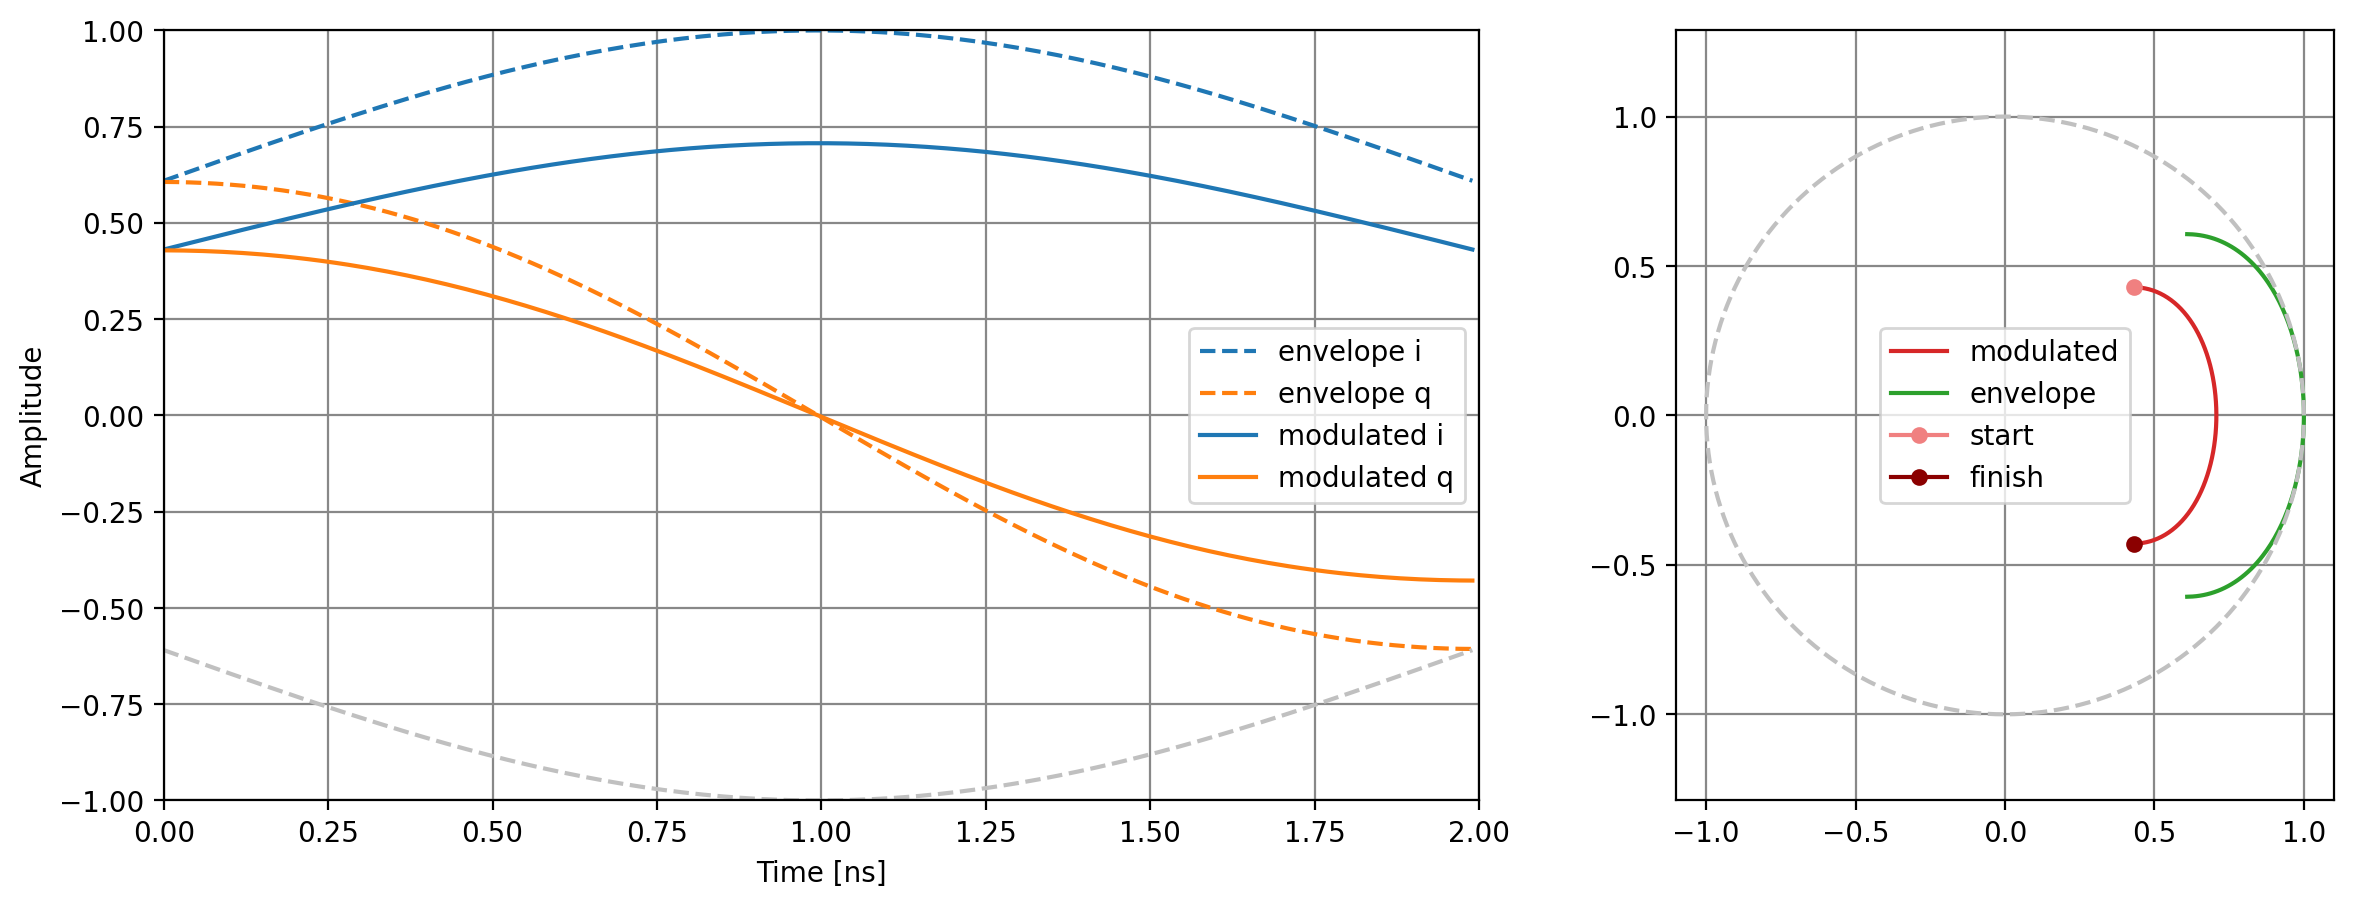

In [19]:
dp = Pulse(0, 2, 1, 4e9, 0, Drag(2,1), 0, PulseType.DRIVE)
dp.plot(sampling_rate=100)
# envelope i & envelope q should cross nearly at 0 and at 2

#### Sudden variant Net Zero

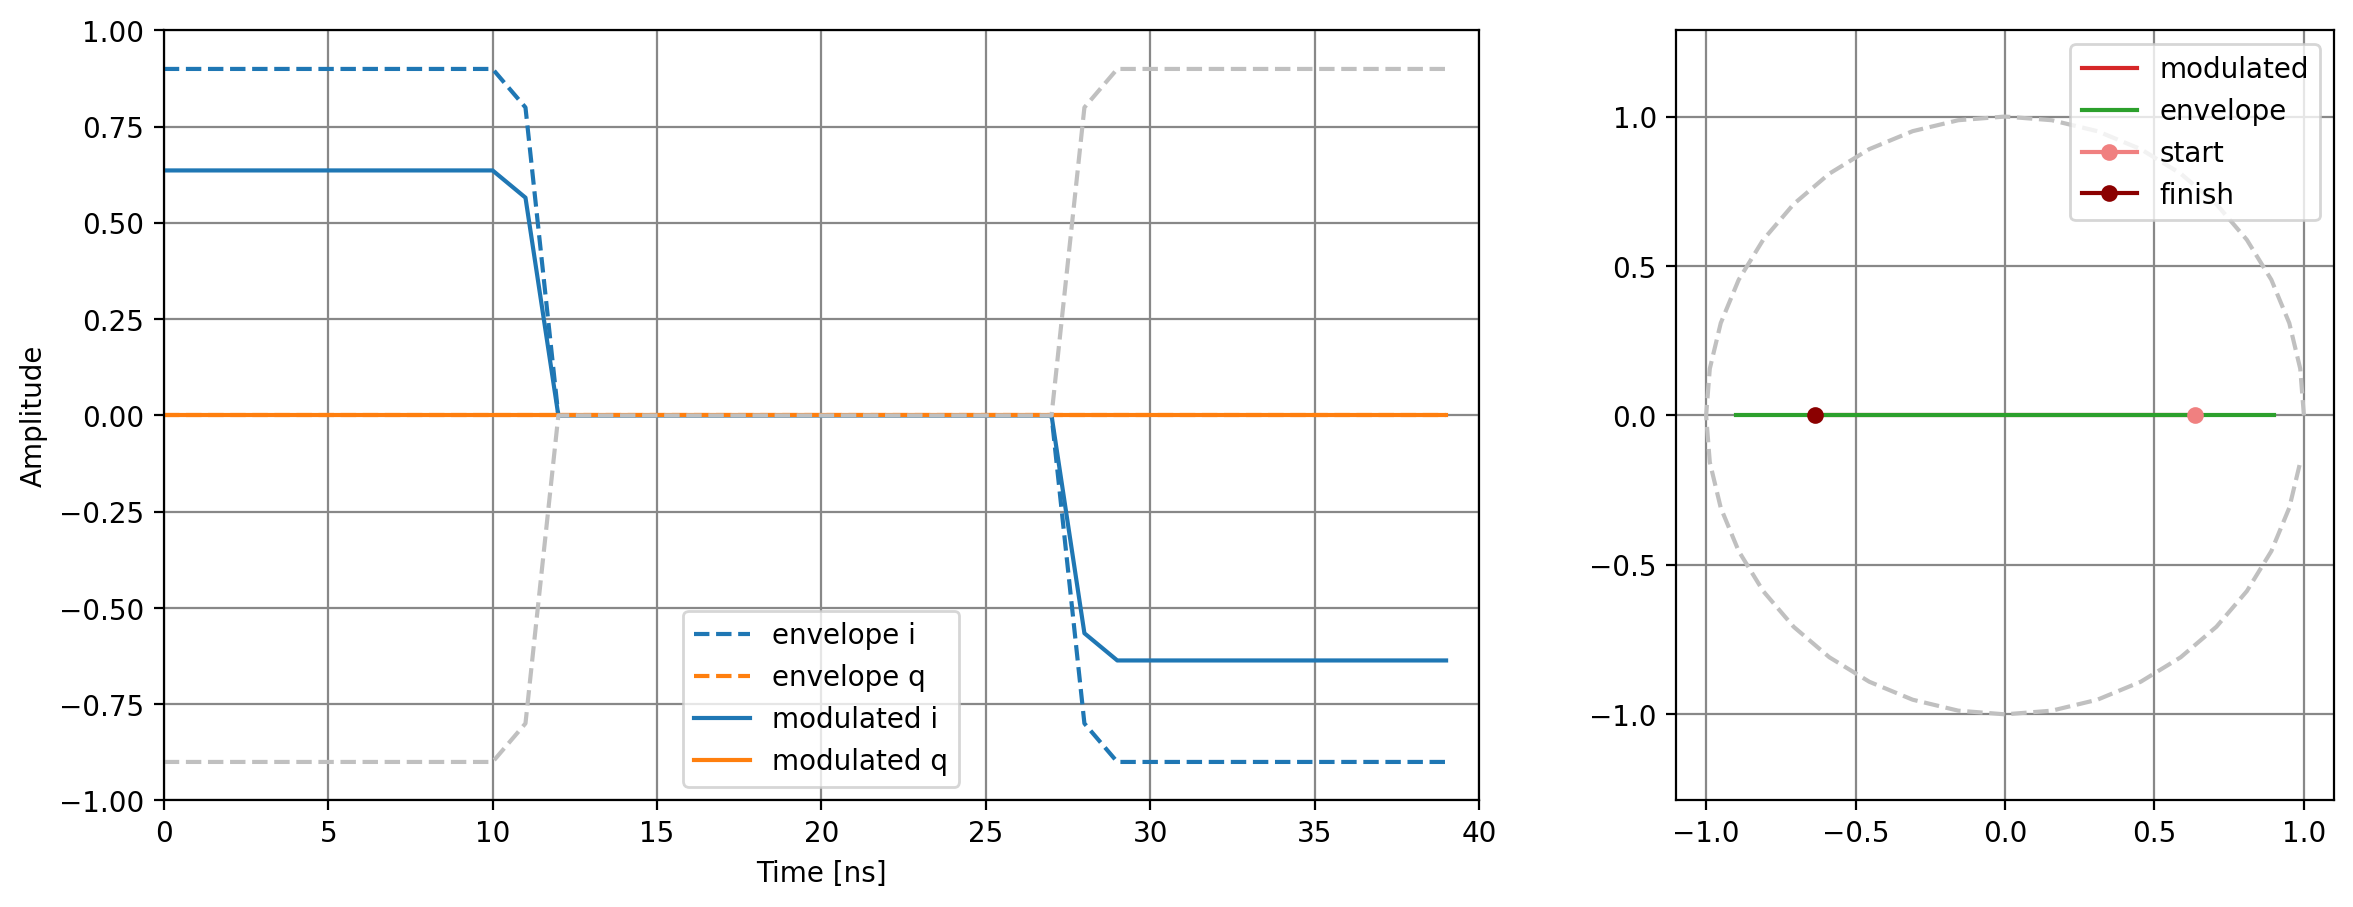

In [20]:
dp = FluxPulse(0, 40, 0.9, SNZ(17, b_amplitude=0.8), 0, 200)
dp.plot()

#### Infinite Impulse Response (Filter) Shape

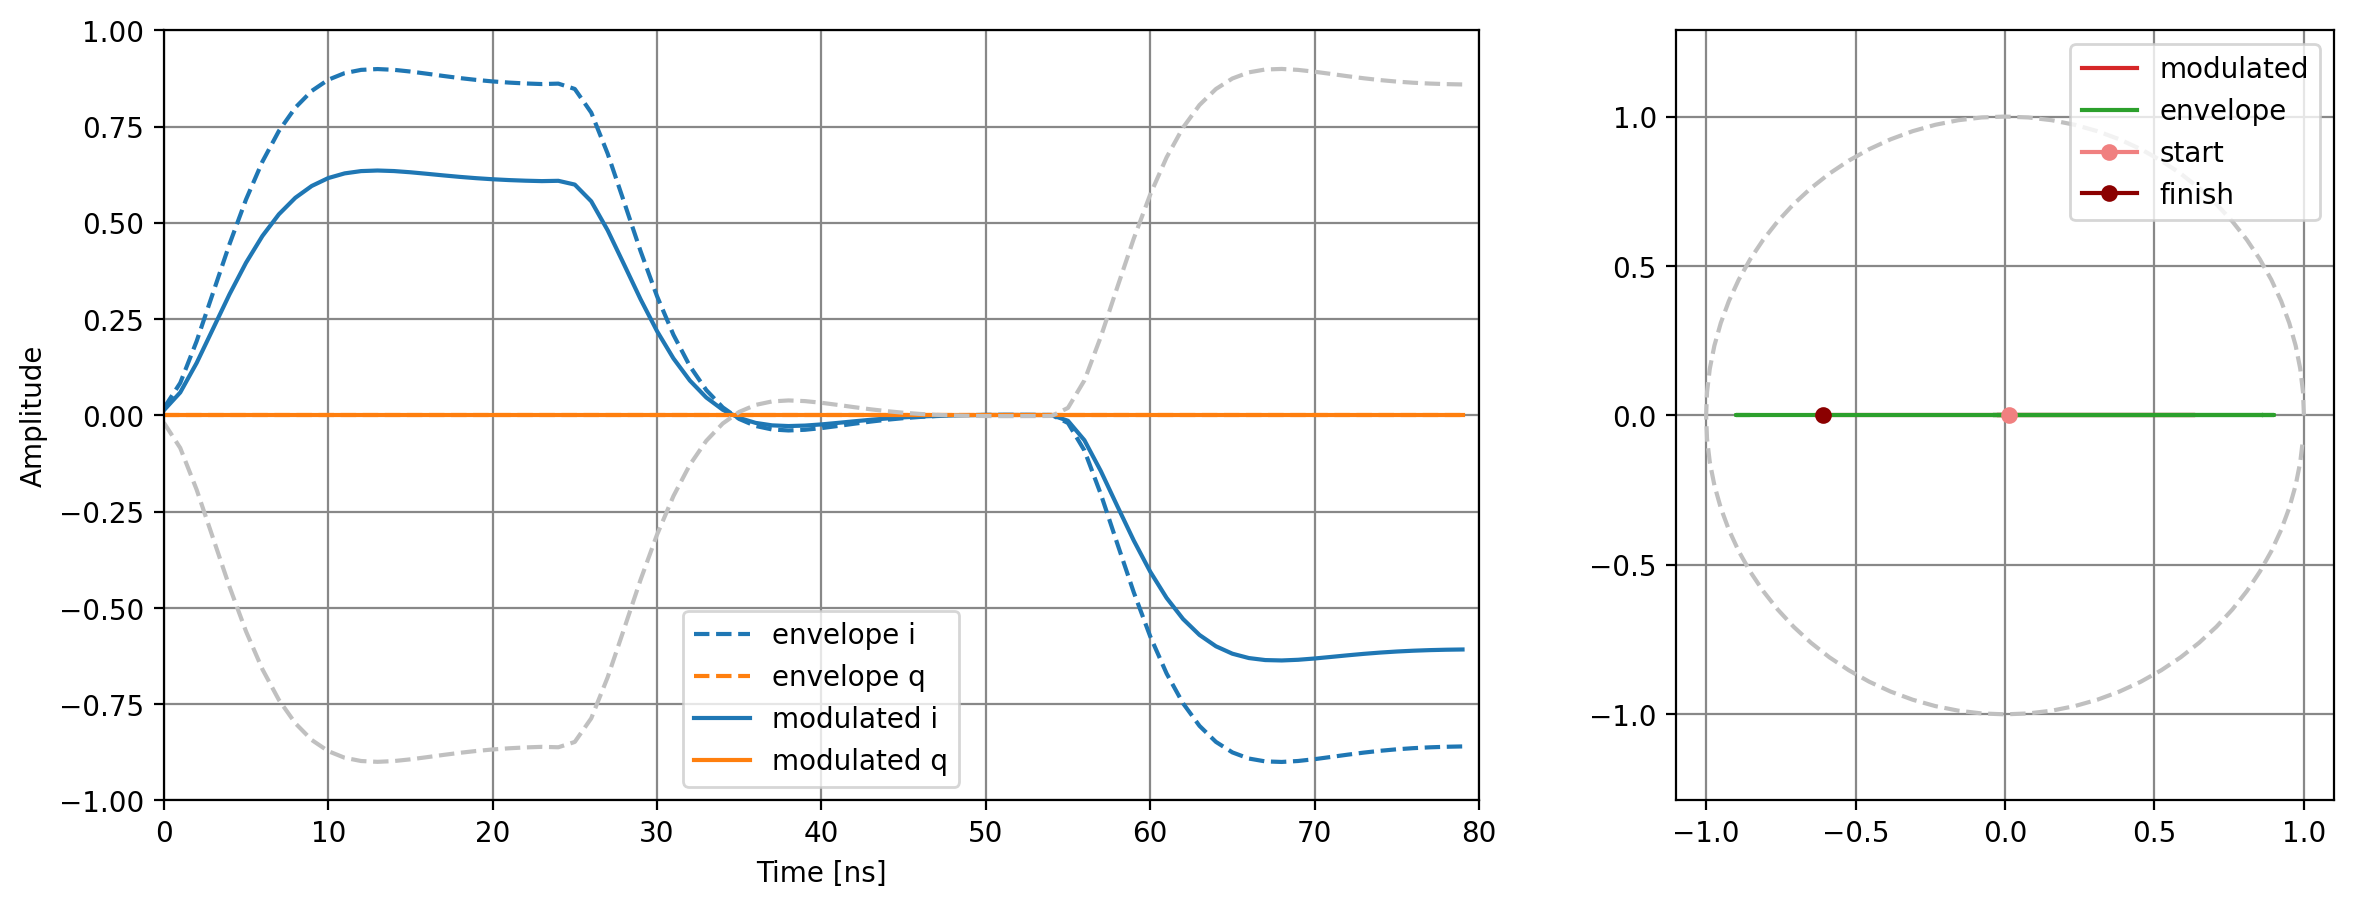

In [21]:
b = [1, 2, 1]
a = [1, -1.5432913909679857, 0.6297148520559599]

# import numpy as np
# http://jaggedplanet.com/iir/iir-explorer.asp
# low pass
# b = np.array([1, 2, 1])
# a = np.flip(np.array([0.277023226134283,-0.7651127295946996,1]))
# high pass
# b = np.array([1, -2, 1])
# a = np.flip(np.array([0.7466573279103673,-1.7095165404698354,1]))

dp = FluxPulse(0, 80, 0.9, IIR(
                            b=b, 
                            a=a,
                            target=SNZ(30, b_amplitude=1)), 
    0, 200)
dp.plot()

### eCap Pulse Shape

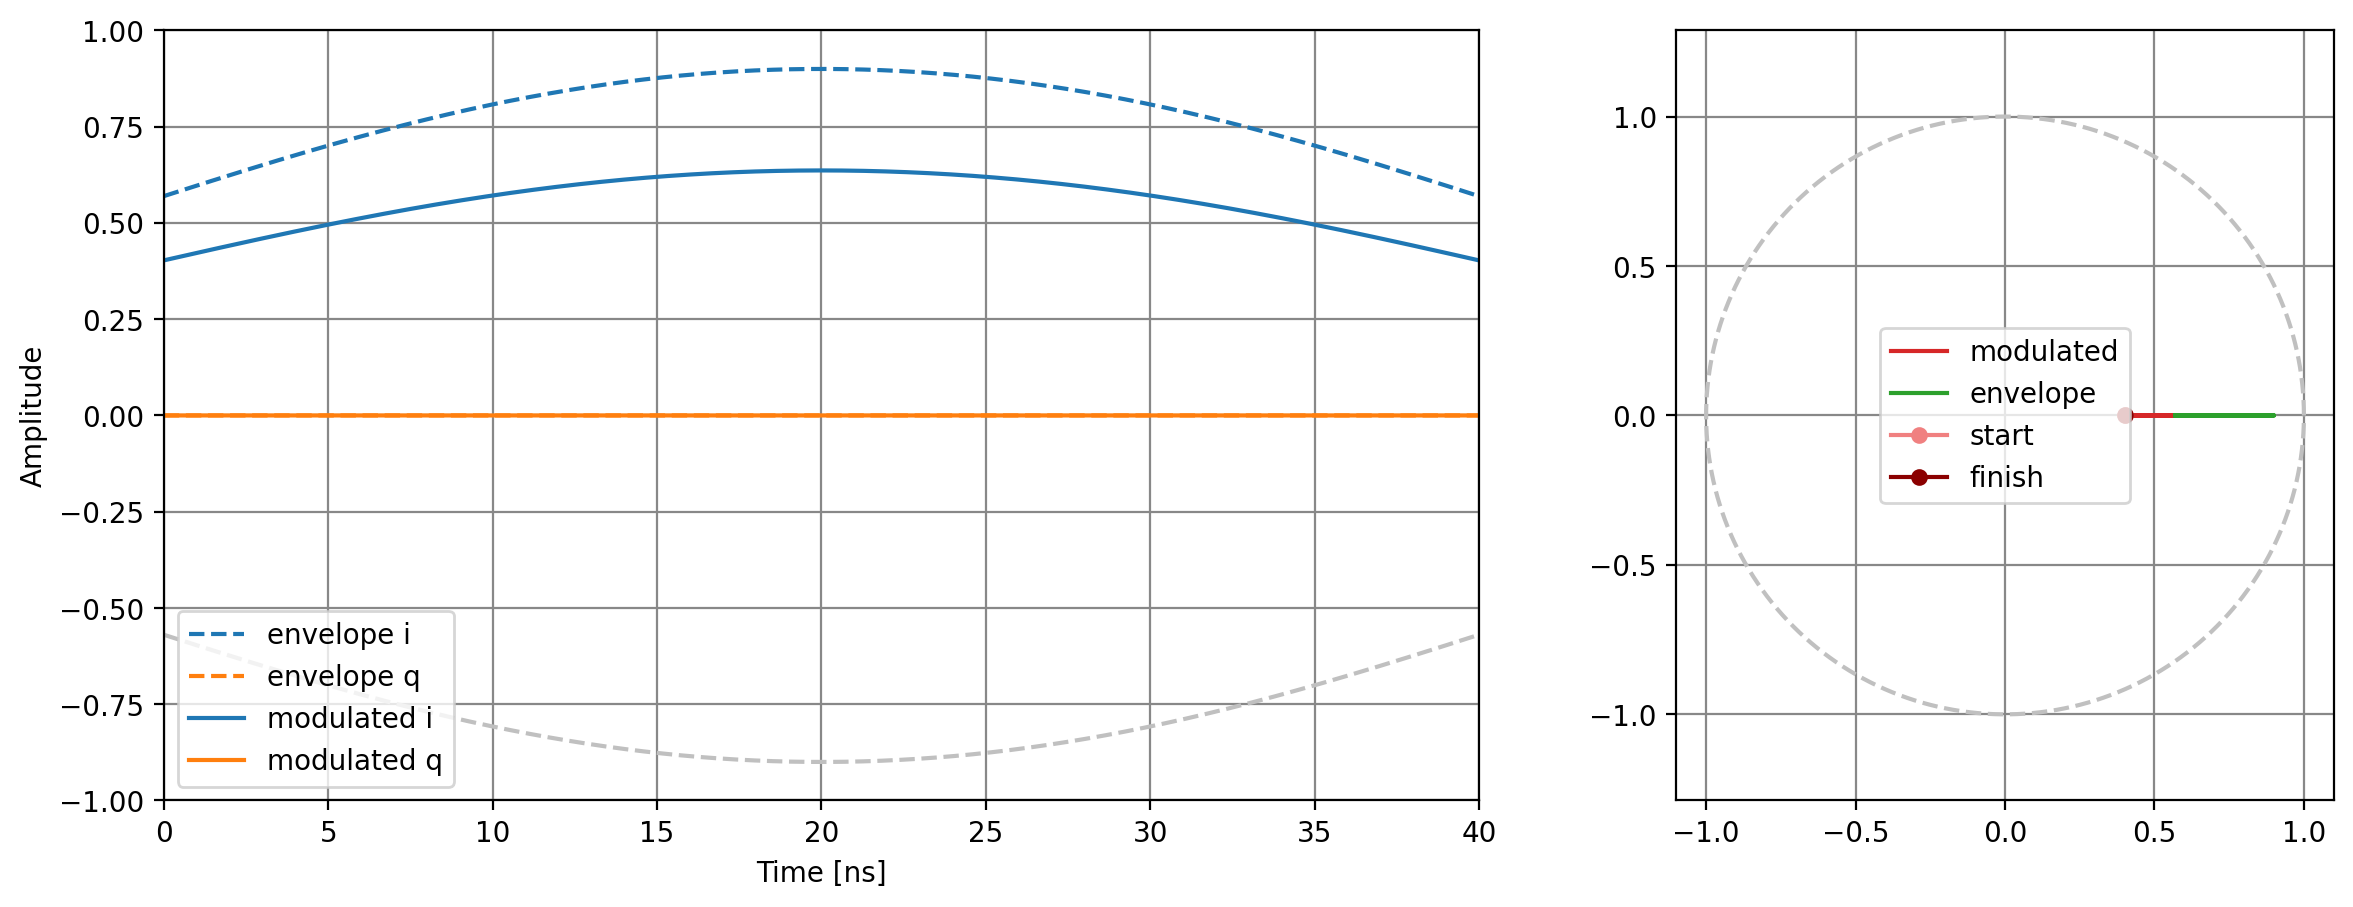

In [22]:
dp = Pulse(0, 40, 0.9, 400e6, 0, eCap(alpha=2), 0, PulseType.DRIVE)
dp.plot(sampling_rate=100)

### Waveform

#### Overview

The `Waveform` object is used to hold the array of samples that make up a waveform. This simple class is hashable so that it allows the comparison of two `Waveforms`, which is later needed by the driver.
The class has a writable `serial` attribute that can be set externally.

In [23]:
duration = 200 # ns
amplitude = 0.9 
num_samples = int(duration) # default sampling rate of 1GSps
waveform = Waveform(amplitude * np.ones(num_samples))
waveform.serial = f"Envelope_Waveform_I(num_samples = {num_samples}, amplitude = {format(amplitude, '.6f').rstrip('0').rstrip('.')}, shape = Rectangular())"
waveform.serial

'Envelope_Waveform_I(num_samples = 200, amplitude = 0.9, shape = Rectangular())'

### Pulse Sequence

#### Overview

One of the key enhancements introduced in this new version of the driver are those related to the `PulseSequence`. Previously, `PulseSequence` wasn't more than an a list to contain the sequence of pulses and two attributes to store the time and phase of the sequence.
The new version of `PulseSequence` introduces many features. It is a sorted collection of pulses with many auxiliary methods.

#### Initialisation

Multiple pulses can be used to initialise a `PulseSequence` or can be added to it:

In [24]:
p1 = Pulse(600, 40, 0.9, 100e6, 0, Drag(5,1), 1, PulseType.DRIVE)
p2 = Pulse(500, 40, 0.9, 100e6, 0, Drag(5,1), 2, PulseType.DRIVE)
p3 = Pulse(400, 40, 0.9, 100e6, 0, Drag(5,1), 3, PulseType.DRIVE)

In [25]:
# initialise an empty PulseSequence
ps = PulseSequence()
assert type(ps) == PulseSequence

In [26]:
# initialise a PulseSequence with multiple pulses at once
ps = PulseSequence(p1, p2, p3)
assert ps.count == 3 and len(ps) ==3
assert ps[0] == p3
assert ps[1] == p2
assert ps[2] == p1
# * please note that pulses are always sorted by channel first and then by their start time

In [27]:
# initialise a PulseSequence with the sum of multiple pulses
other_ps = p1 + p2 + p3
assert other_ps.count == 3 and len(other_ps) ==3
assert other_ps[0] == p3
assert other_ps[1] == p2
assert other_ps[2] == p1
# * please note that pulses are always sorted by channel first and then by their start time

plist = [p3, p2, p1]
n = 0
for pulse in ps:
    assert plist[n] == pulse
    n += 1

In [28]:
p4 = Pulse(300, 40, 0.9, 50e6, 0, Gaussian(5), 1, PulseType.DRIVE)
p5 = Pulse(200, 40, 0.9, 50e6, 0, Gaussian(5), 2, PulseType.DRIVE)
p6 = Pulse(100, 40, 0.9, 50e6, 0, Gaussian(5), 3, PulseType.DRIVE)


In [29]:
# multiple pulses can be added at once
yet_another_ps = PulseSequence()
yet_another_ps.add(p4)
yet_another_ps.add(p5, p6)
assert yet_another_ps[0] == p6
assert yet_another_ps[1] == p5
assert yet_another_ps[2] == p4

AssertionError: 

#### Operators

PulseSequence support a number of operators(`==`, `!=`, `+`, `+=`, `*`, `*=`). Below are a few examples:

In [ ]:
ps += yet_another_ps
assert ps.count == 6
ps += ReadoutPulse(800, 200, 0.9, 20e6, 0, Rectangular(), 1)
ps = ps + ReadoutPulse(800, 200, 0.9, 20e6, 0, Rectangular(), 2)
ps = ReadoutPulse(800, 200, 0.9, 20e6, 0, Rectangular(), 3) + ps
assert ps.count == 9
print(ps)

In [ ]:
ps.plot()

`PulseSequence` now implements `__contains__()` so one can check if a `Pulse` is included in the `PulseSequence` likw so: 

In [ ]:
assert p5 in ps

#### Attributes & Methods

`PulseSequence` includes the following (read only) attributes:
- `pulses` a list containing the pulses of the sequence
- `serial`
- `count`
- `is_empty`
- `start`
- `finish`
- `duration`
- `channels`
- `pulses_overlap`
- `channels`
- `ro_pulses`
- `qd_pulses`
- `qf_pulses`


`PulseSequence` implements the following methods:
- `add()`
- `pop()`
- `remove()`
- `clear()`
- `shallow_copy()`
- `deep_copy()`
- `get_channel_pulses()`
- `get_pulse_overlaps()` returns a dictionary of time intervals with the list of pulses in it
- `separate_overlapping_pulses()`
- `plot()`

In [ ]:
p1 = Pulse(600, 40, 0.9, 100e6, 0, Drag(5,1), 1, PulseType.DRIVE)
ps = PulseSequence(p1)
assert ps.count == 1
ps *= 3
assert ps.count == 3
ps *= 3
assert ps.count == 9

In [ ]:
p1 = Pulse(600, 40, 0.9, 100e6, 0, Drag(5,1), 1, PulseType.DRIVE)
p2 = Pulse(600, 40, 0.9, 100e6, 0, Drag(5,1), 2, PulseType.DRIVE)
ps = 2 * p2 + p1 * 3
assert ps.count == 5

In [ ]:
ps.clear()
assert ps.count == 0
assert ps.is_empty

In [ ]:
p1 = Pulse(20, 40, 0.9, 200e6, 0, Drag(5,1), 1, PulseType.DRIVE)
p2 = Pulse(60, 1000, 0.9, 20e6, 0, Rectangular(), 2, PulseType.READOUT)
ps = p1 + p2
assert ps.start == p1.start
assert ps.finish == p2.finish


In [ ]:
p1 = DrivePulse(0, 400, 0.9, 20e6, 0, Gaussian(5), 10)
p2 = ReadoutPulse(100, 400, 0.9, 20e6, 0, Rectangular(), 30)
p3 = DrivePulse(300, 400, 0.9, 20e6, 0, Drag(5,50), 20)
p4 = DrivePulse(400, 400, 0.9, 20e6, 0, Drag(5,50), 30)
p5 = ReadoutPulse(500, 400, 0.9, 20e6, 0, Rectangular(), 20)
p6 = DrivePulse(600, 400, 0.9, 20e6, 0, Gaussian(5), 30)

ps = PulseSequence(p1, p2, p3, p4, p5, p6)
assert ps.channels == [10, 20, 30]
assert ps.get_channel_pulses(10).count == 1 
assert ps.get_channel_pulses(20).count == 2 
assert ps.get_channel_pulses(30).count == 3 

In [ ]:
ps.plot()

In [ ]:
assert ps.pulses_overlap == True
assert ps.get_channel_pulses(10).pulses_overlap == False
assert ps.get_channel_pulses(20).pulses_overlap == True
assert ps.get_channel_pulses(30).pulses_overlap == True

channel10_ps = ps.get_channel_pulses(10)
channel20_ps = ps.get_channel_pulses(20)
channel30_ps = ps.get_channel_pulses(30)

split_pulses = PulseSequence()
overlaps = channel20_ps.get_pulse_overlaps()
n = 0
for section in overlaps.keys():
    for pulse in overlaps[section]:
        sp = SplitPulse(pulse, section[0], section[1])
        sp.channel = n
        split_pulses.add(sp)
        n += 1
split_pulses.plot()



In [ ]:
n = 70
for segregated_ps in ps.separate_overlapping_pulses():
    n +=1
    for pulse in segregated_ps:
        pulse.channel = n
ps.plot()

In [ ]:
p1 = DrivePulse(t0, 400, 0.9, 20e6, 0, Gaussian(5), 10)
p2 = ReadoutPulse(p1.finish, 400, 0.9, 20e6, 0, Rectangular(), 30)
p3 = DrivePulse(p2.finish, 400, 0.9, 20e6, 0, Drag(5,50), 20)
ps1 = p1 + p2 + p3
ps2 = p3 + p1 + p2
assert ps1 == ps2

#### Overlaps

In [ ]:
overlaps